# Imports and data

In [80]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score, davies_bouldin_score
from gower import gower_matrix
from kmodes.kprototypes import KPrototypes
from kmodes.kmodes import KModes
from prince import FAMD

import pickle

from IPython.display import display

In [81]:
raw_data_customers = pd.read_csv('customers.csv', index_col=0)

In [82]:
df_customers = raw_data_customers.copy()

In [83]:
cols_categorical = ['Sex', 'Marital status', 'Education', 'Occupation', 'Settlement size']
cols_numerical = ['Age', 'Income']

df_customers_cats = df_customers[cols_categorical].apply(lambda col: col.astype('category').cat.codes)
df_customers_nums = df_customers[cols_numerical]

scaler_nums = StandardScaler()
customers_nums_scaled = scaler_nums.fit_transform(df_customers_nums)

encoder_cats = OneHotEncoder(sparse_output=False)
customers_cats_encoded = encoder_cats.fit_transform(df_customers_cats)

customers_scaled_and_encoded  = np.hstack((customers_nums_scaled, customers_cats_encoded))

scaler = StandardScaler()
customers_scaled = scaler.fit_transform(df_customers)

# Data exploration

Column | Values | Labels
--- | --- | ---
Sex | 0-1 | male, female
Martial status | 0-1 | single, married
Education | 0-3 | other/unknown, high school, uni, grad school
Ocupation | 0-2 | unemployed/unskilled, skilled, management/self-employed
Settlement size | 0-2 | small, medium, large

In [84]:
display(df_customers.head())
display(df_customers.describe())

Sex  Marital status  Age  Education  Income  Occupation  \
ID                                                                   
100000001    0               0   67          2  124670           1   
100000002    1               1   22          1  150773           1   
100000003    0               0   49          1   89210           0   
100000004    0               0   45          1  171565           1   
100000005    0               0   53          1  149031           1   

           Settlement size  
ID                          
100000001                2  
100000002                2  
100000003                0  
100000004                1  
100000005                1

Sex  Marital status          Age   Education         Income  \
count  2000.000000     2000.000000  2000.000000  2000.00000    2000.000000   
mean      0.457000        0.496500    35.909000     1.03800  120954.419000   
std       0.498272        0.500113    11.719402     0.59978   38108.824679   
min       0.000000        0.000000    18.000000     0.00000   35832.000000   
25%       0.000000        0.000000    27.000000     1.00000   97663.250000   
50%       0.000000        0.000000    33.000000     1.00000  115548.500000   
75%       1.000000        1.000000    42.000000     1.00000  138072.250000   
max       1.000000        1.000000    76.000000     3.00000  309364.000000   

        Occupation  Settlement size  
count  2000.000000      2000.000000  
mean      0.810500         0.739000  
std       0.638587         0.812533  
min       0.000000         0.000000  
25%       0.000000         0.000000  
50%       1.000000         1.000000  
75%       1.000000         1.000000  
max       2.000000         2.000000

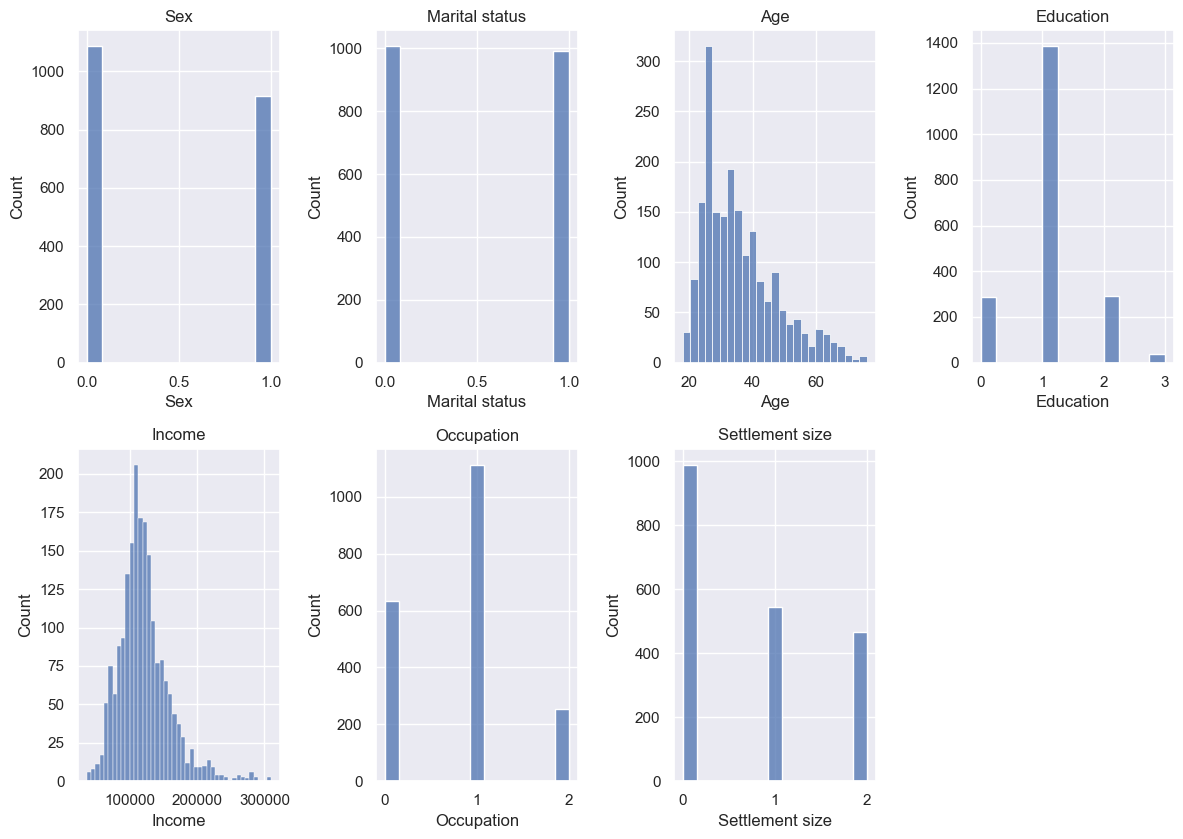

In [85]:
plt.figure(figsize=(12,9))
for i, column in enumerate(df_customers.columns):
    plt.subplot(2,4,i+1)
    sns.histplot(df_customers[column])
    plt.title(column)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

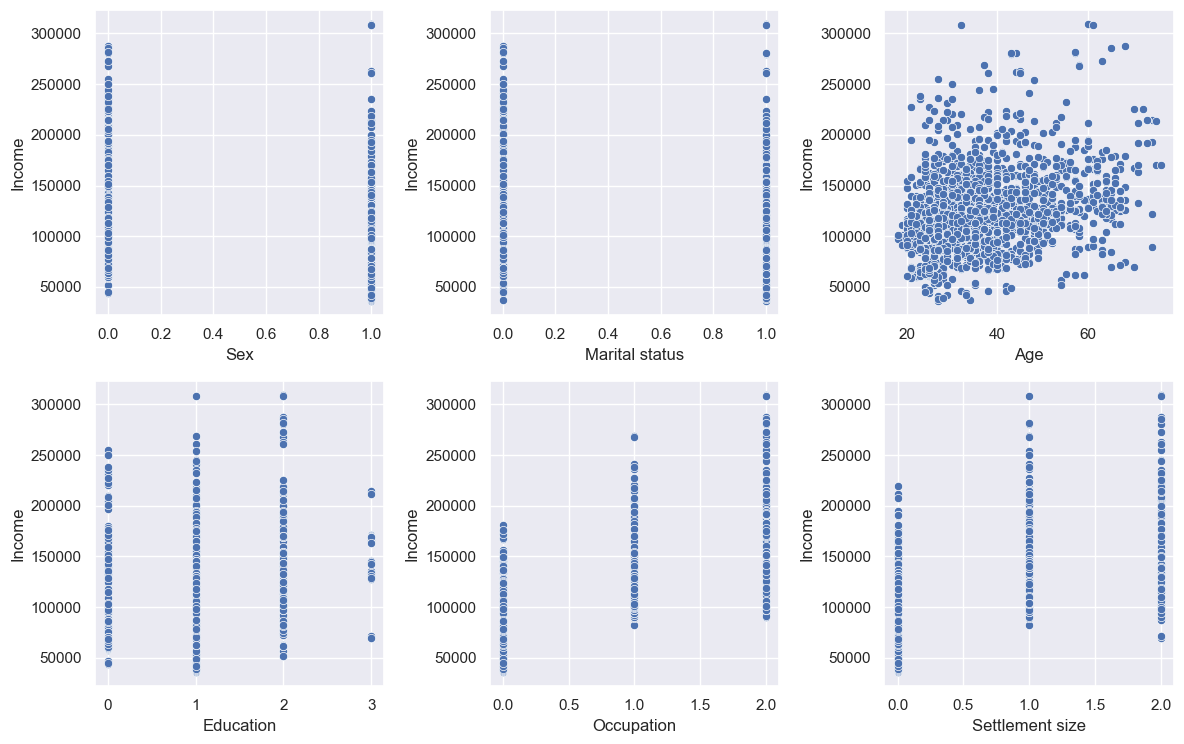

In [86]:
plt.figure(figsize=(12,8))
for i, column in enumerate(df_customers.columns.drop('Income')):
    plt.subplot(2,3,i+1)
    sns.scatterplot(data=df_customers, x=column, y='Income')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

In [87]:
df_customers[df_customers['Education']==3].describe()

Sex  Marital status        Age  Education         Income  \
count  36.000000       36.000000  36.000000       36.0      36.000000   
mean    0.805556        0.944444  57.000000        3.0  146818.333333   
std     0.401386        0.232311  17.381435        0.0   37635.665122   
min     0.000000        0.000000  25.000000        3.0   69487.000000   
25%     1.000000        1.000000  36.250000        3.0  131242.000000   
50%     1.000000        1.000000  65.500000        3.0  143561.500000   
75%     1.000000        1.000000  67.750000        3.0  169521.250000   
max     1.000000        1.000000  76.000000        3.0  214364.000000   

       Occupation  Settlement size  
count   36.000000        36.000000  
mean     1.055556         1.000000  
std      0.753826         0.894427  
min      0.000000         0.000000  
25%      0.750000         0.000000  
50%      1.000000         1.000000  
75%      2.000000         2.000000  
max      2.000000         2.000000

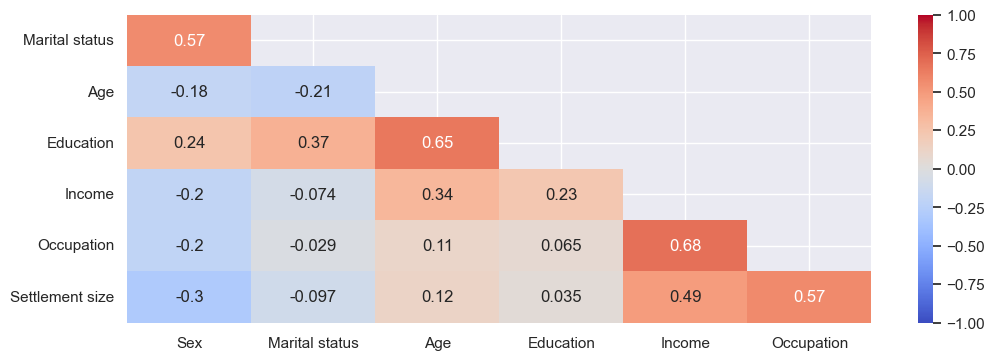

In [88]:
plt.figure(figsize=(12,4))
corr = df_customers.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
s = sns.heatmap(corr.iloc[1:,:-1], mask=mask[1:,:-1], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

In [89]:
df_customers['Sex'] = df_customers['Sex'].astype('int64')
df_customers['Marital status'] = df_customers['Marital status'].astype('int64')
df_customers['Education'] = df_customers['Education'].astype('int64')
df_customers['Occupation'] = df_customers['Occupation'].astype('int64')
df_customers['Settlement size'] = df_customers['Settlement size'].astype('int64')

# Clustering

## Hierarchical

### Dendograms

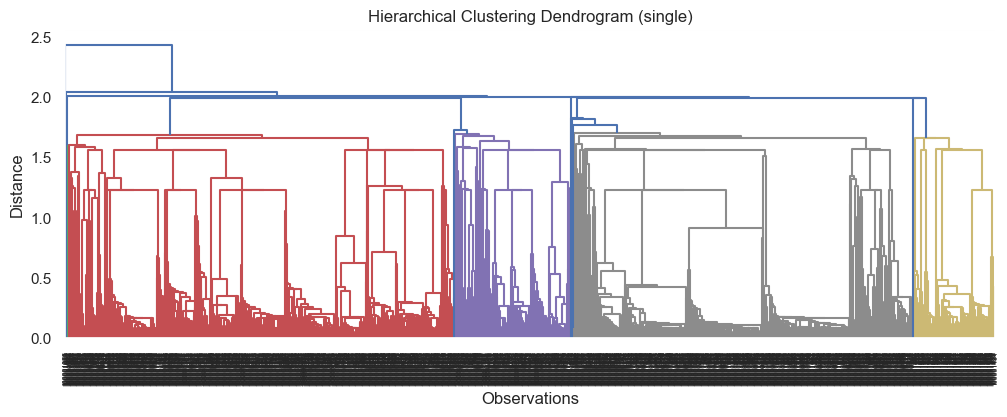

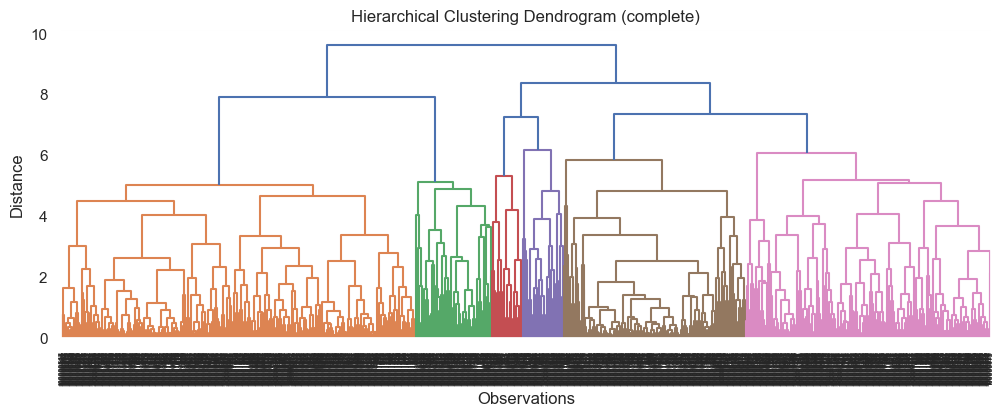

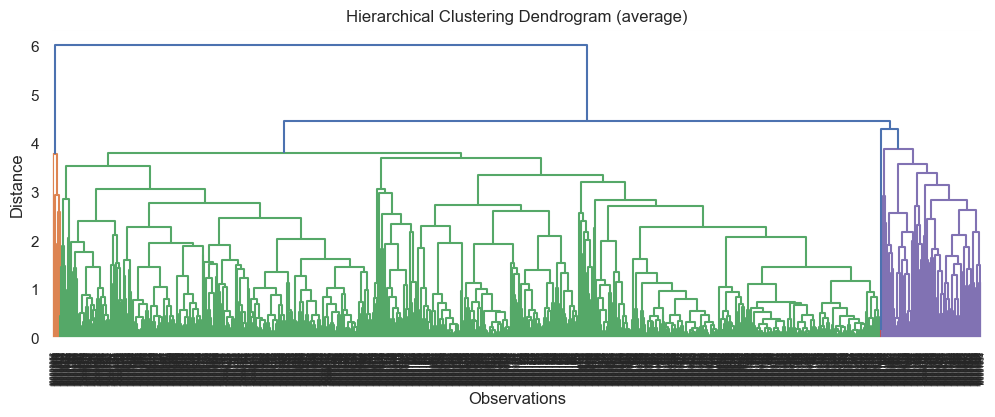

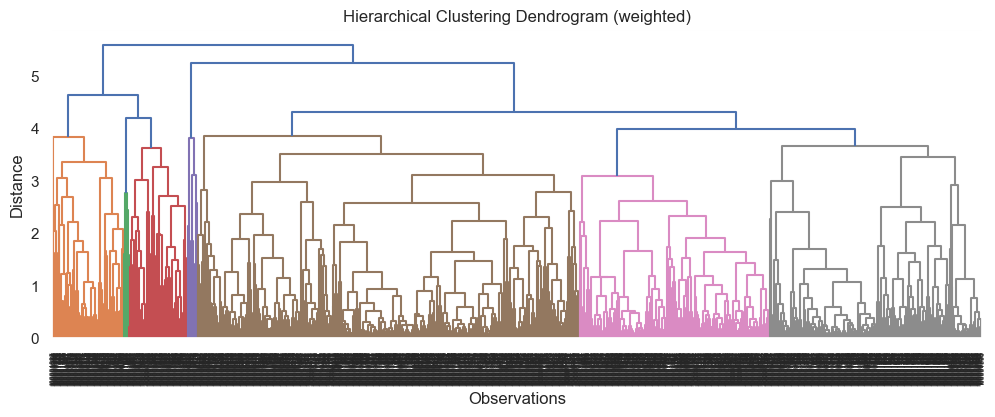

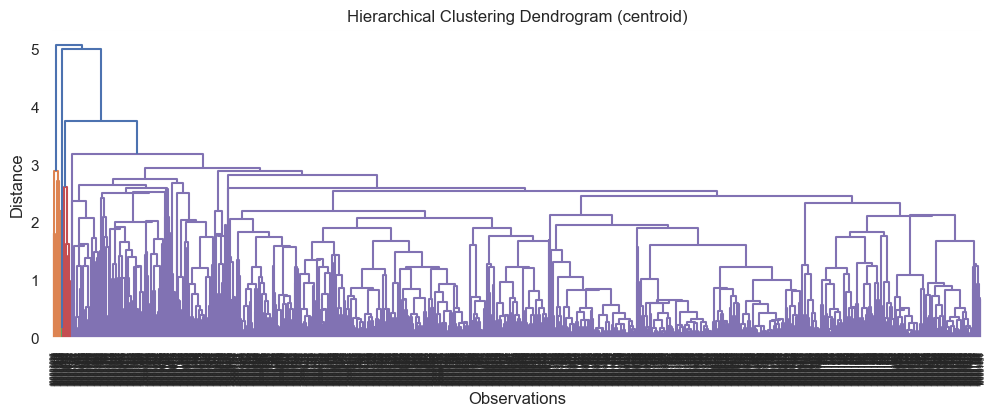

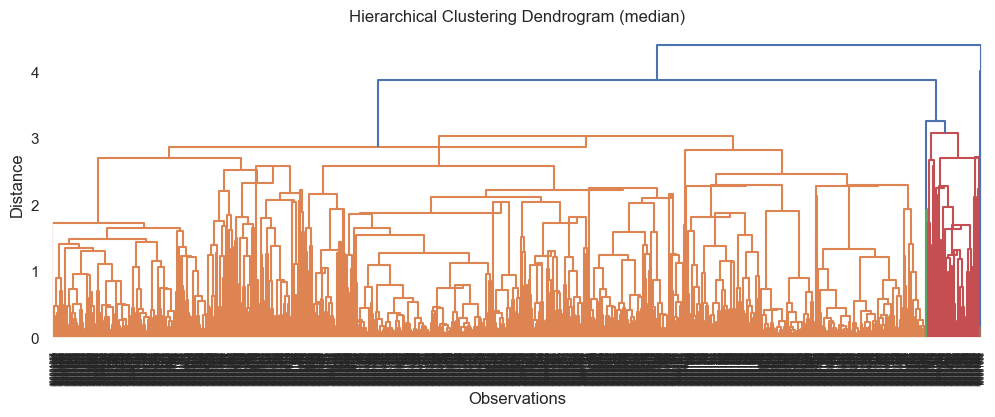

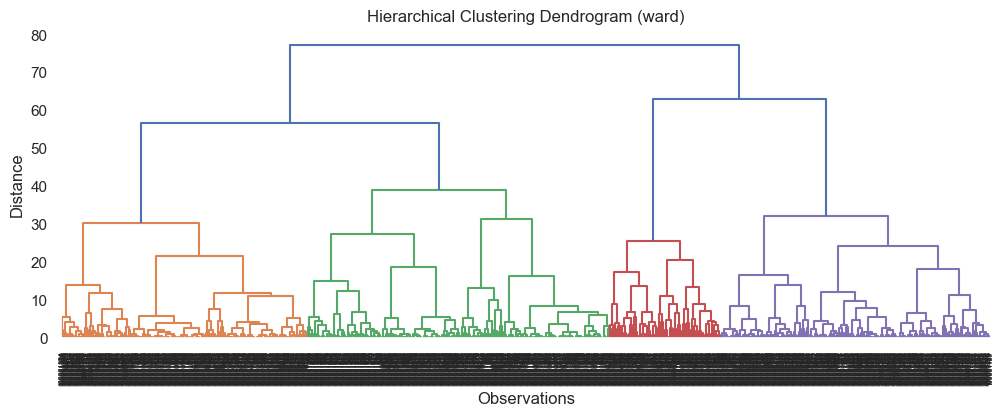

In [90]:
df_customers_hier = df_customers.copy()

hier_methods = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']
for method in hier_methods:
    hier_clust = linkage(customers_scaled, method=method)

    plt.figure(figsize=(12,4))
    plt.title(f'Hierarchical Clustering Dendrogram ({method})')
    plt.xlabel('Observations')
    plt.ylabel('Distance')
    dendrogram(hier_clust, show_leaf_counts=True, labels=df_customers.index, leaf_rotation=90)
    plt.show()

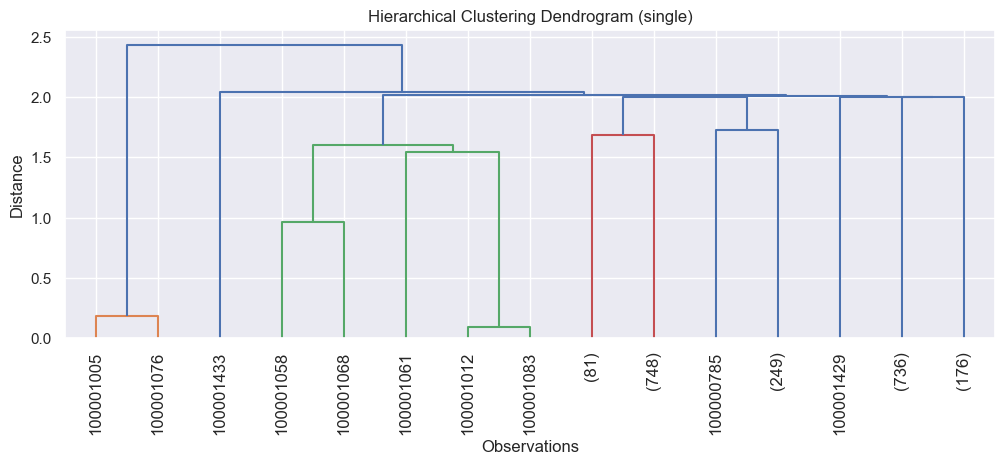

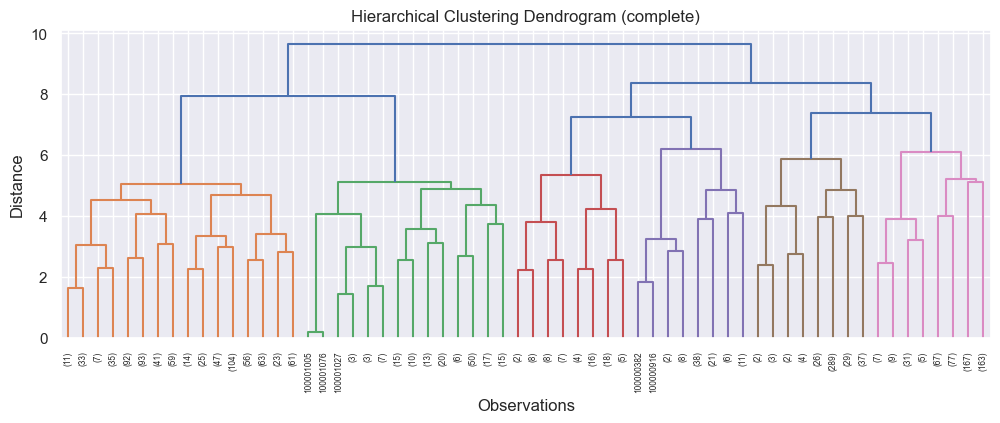

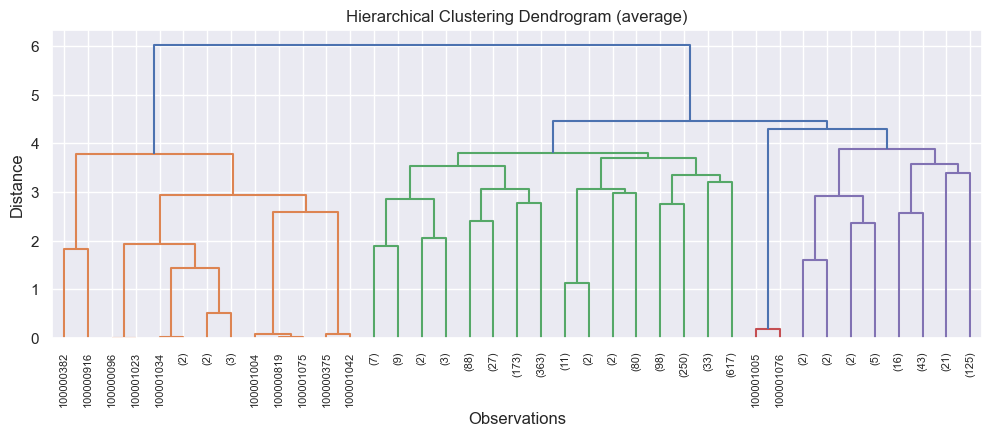

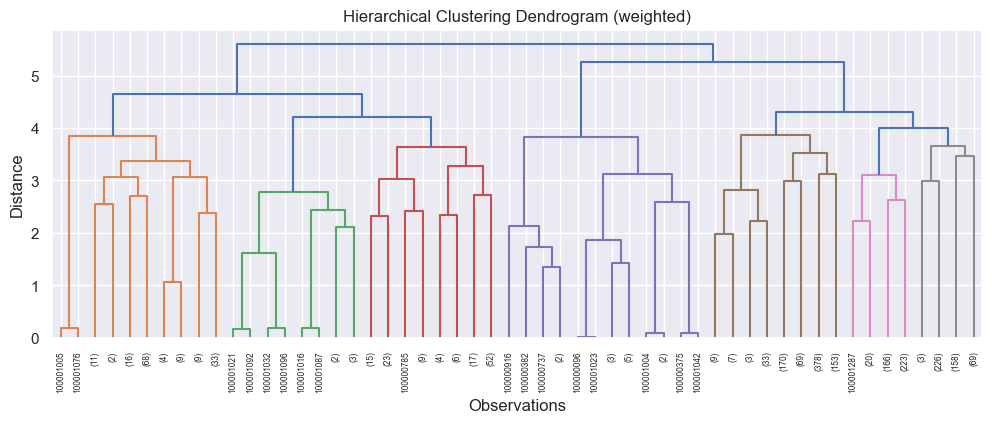

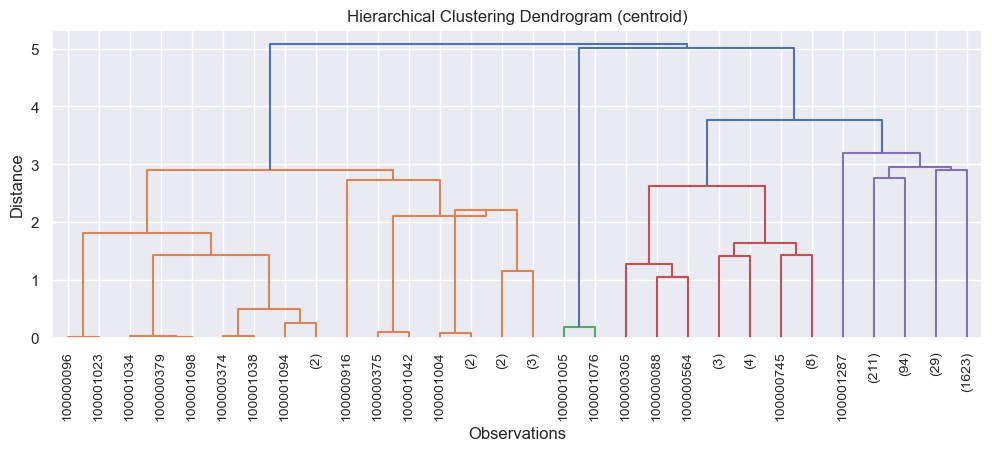

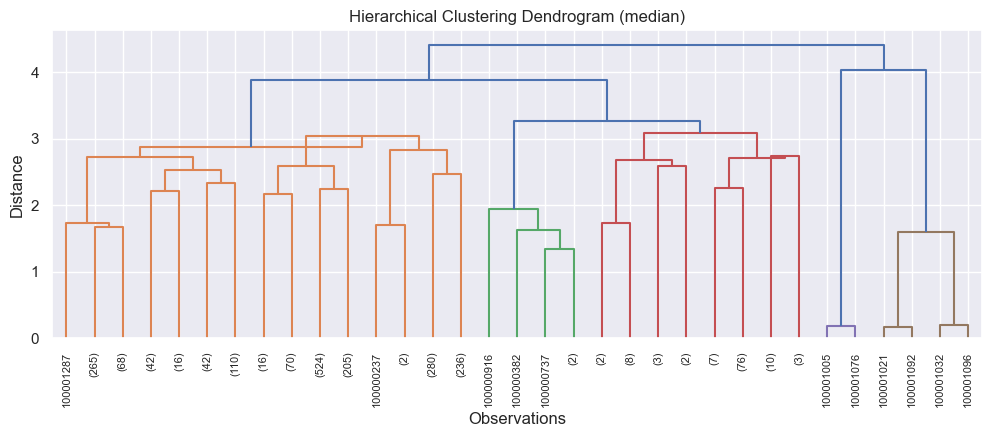

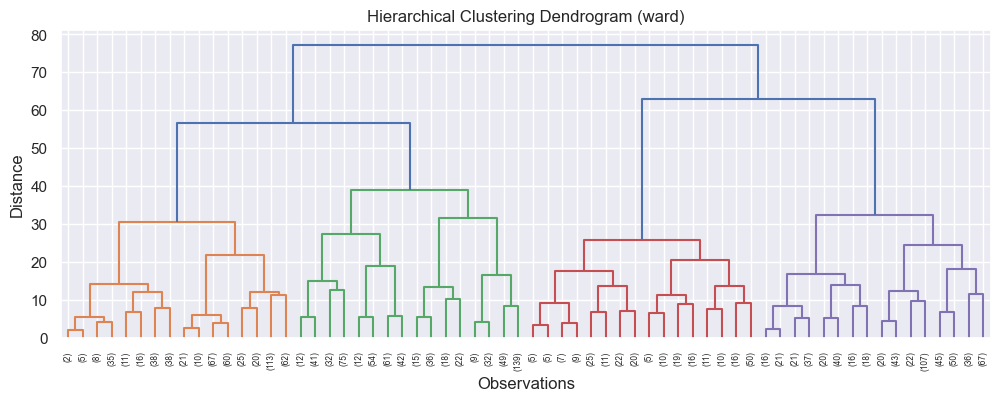

In [91]:
hier_methods = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']
for method in hier_methods:
    hier_clust = linkage(customers_scaled, method=method)

    plt.figure(figsize=(12,4))
    plt.title(f'Hierarchical Clustering Dendrogram ({method})')
    plt.xlabel('Observations')
    plt.ylabel('Distance')
    dendrogram(hier_clust, truncate_mode='level', p=5, show_leaf_counts=True, labels=df_customers.index, leaf_rotation=90)
    plt.show()

### 4 clusters

Sex  Marital status    Age  Education     Income  Occupation  \
Cluster (hier)                                                                  
1               0.50            0.51  34.62       1.00  115413.11        0.82   
2               0.56            0.54  31.91       0.90   81766.74        0.24   
3               0.31            0.45  40.70       1.19  152156.74        1.23   
4               0.29            0.40  44.73       1.35  223444.56        1.75   

                Settlement size  
Cluster (hier)                   
1                          0.72  
2                          0.21  
3                          1.22  
4                          1.45

Sex  Marital status   Age  Education    Income  Occupation  \
Cluster (hier)                                                               
1               0.0             1.0  32.0        1.0  114784.0         1.0   
2               1.0             1.0  29.0        1.0   84596.5         0.0   
3               0.0             0.0  37.0        1.0  149653.0         1.0   
4               0.0             0.0  43.0        1.0  214364.0         2.0   

                Settlement size  
Cluster (hier)                   
1                           0.0  
2                           0.0  
3                           1.0  
4                           2.0

Sex  Marital status  Age  Education  Income  Occupation  \
Cluster (hier)                                                            
1                 0               1   26          1  102543           1   
2                 1               1   26          1   69487           0   
3                 0               0   30          1  133328           1   
4                 0               0   42          2  214364           2   

                Settlement size  
Cluster (hier)                   
1                             0  
2                             0  
3                             1  
4                             2

Sex  Marital status        Age  Education         Income  \
Cluster (hier)                                                                  
1               0.495828        0.512515  34.618594   1.000000  115413.113230   
2               0.558929        0.535714  31.907143   0.898214   81766.741071   
3               0.311609        0.446029  40.702648   1.193483  152156.739308   
4               0.290909        0.400000  44.727273   1.345455  223444.563636   

                Occupation  Settlement size    #       %  
Cluster (hier)                                            
1                 0.824791         0.716329  839  0.4195  
2                 0.239286         0.214286  560  0.2800  
3                 1.228106         1.215886  491  0.2455  
4                 1.745455         1.454545  110  0.0550

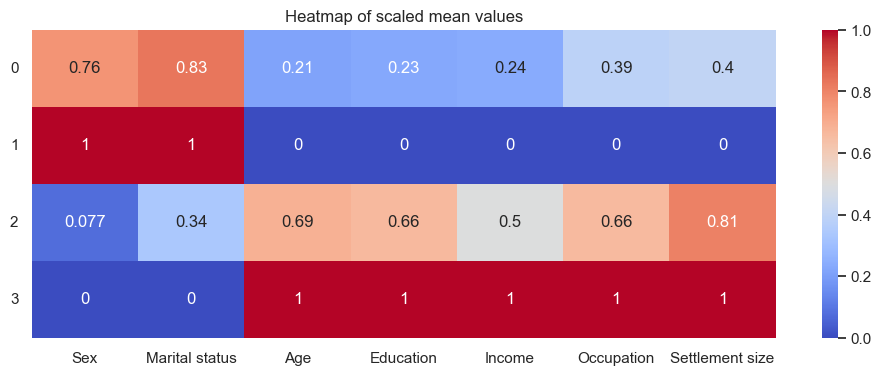

Sex  Marital status  \
Cluster (hier)                                                                 
Very average                                        0.495828        0.512515   
Below average careers, mostly younger married w...  0.558929        0.535714   
Above average careers, mostly older unmarried men   0.311609        0.446029   
Older men with successful careers in big cities     0.290909        0.400000   

                                                          Age  Education  \
Cluster (hier)                                                             
Very average                                        34.618594   1.000000   
Below average careers, mostly younger married w...  31.907143   0.898214   
Above average careers, mostly older unmarried men   40.702648   1.193483   
Older men with successful careers in big cities     44.727273   1.345455   

                                                           Income  Occupation  \
Cluster (hier)                                                                  
Very average                                        115413.113230    0.824791   
Below average careers, mostly younger married w...   81766.741071    0.239286   
Above average careers, mostly older unmarried men   152156.739308    1.228106   
Older men with successful careers in big cities     223444.563636    1.745455   

                                                    Settlement size    #  \
Cluster (hier)                                                             
Very average                                               0.716329  839   
Below average careers, mostly younger married w...         0.214286  560   
Above average careers, mostly older unmarried men          1.215886  491   
Older men with successful careers in big cities            1.454545  110   

                                                         %  
Cluster (hier)                                              
Very average                                        0.4195  
Below average careers, mostly younger married w...  0.2800  
Above average careers, mostly older unmarried men   0.2455  
Older men with successful careers in big cities     0.0550

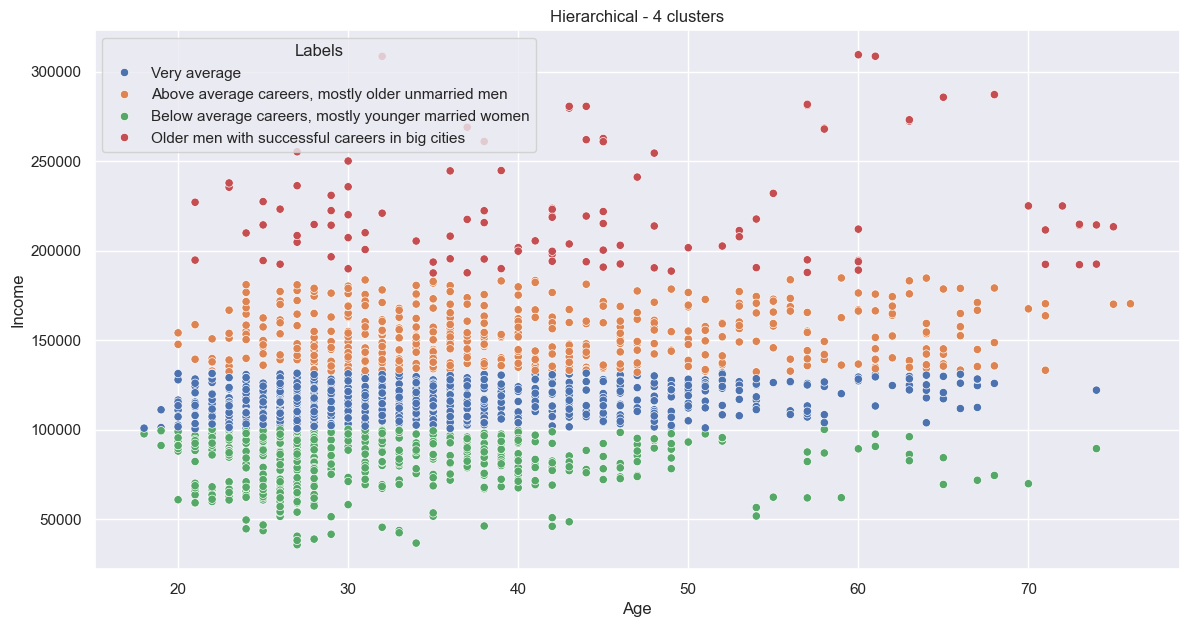

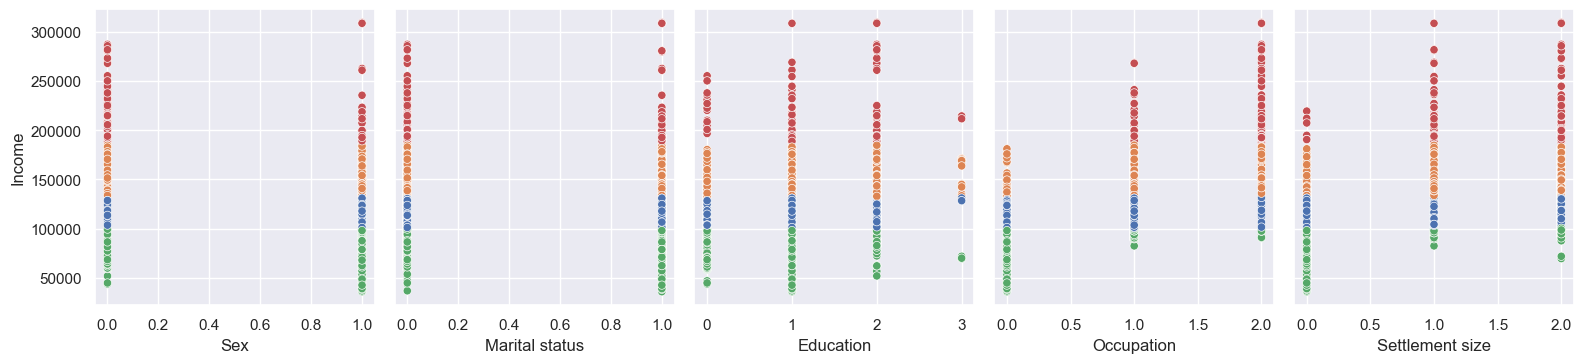

In [92]:
df_customers_hier_4 = df_customers.copy()
Z = linkage(df_customers_hier_4, method='ward')
clusters_hier = fcluster(Z, t=4, criterion='maxclust')

df_customers_hier_4['Cluster (hier)'] = clusters_hier

display(df_customers_hier_4.groupby(['Cluster (hier)']).mean().round(2))
display(df_customers_hier_4.groupby(['Cluster (hier)']).median())
display(df_customers_hier_4.groupby(['Cluster (hier)']).agg(lambda x: x.mode()[0]))

df_customers_hier_4_analysis = df_customers_hier_4.groupby(['Cluster (hier)']).mean()
df_customers_hier_4_analysis['#'] = df_customers_hier_4[['Cluster (hier)','Sex']].groupby(['Cluster (hier)']).count()
df_customers_hier_4_analysis['%'] = df_customers_hier_4_analysis['#'] / df_customers_hier_4_analysis['#'].sum()

display(df_customers_hier_4_analysis)

scaler_hier_analysis_4 = MinMaxScaler()
df_customers_hier_4_analysis_scaled = pd.DataFrame(scaler_hier_analysis_4.fit_transform(df_customers_hier_4_analysis), columns=df_customers_hier_4_analysis.columns)
plt.figure(figsize=(12,4))
plt.title('Heatmap of scaled mean values')
s = sns.heatmap(df_customers_hier_4_analysis_scaled.drop(['#','%'], axis=1), annot=True, cmap='coolwarm', vmin=0, vmax=1)
s.set_yticklabels(s.get_yticklabels(), rotation=0)
plt.show()

mapping_hier_4 = {  1:'Very average',
                    2:'Below average careers, mostly younger married women',
                    3:'Above average careers, mostly older unmarried men',
                    4:'Older men with successful careers in big cities'}
df_customers_hier_4_analysis.rename(mapping_hier_4, inplace=True)
display(df_customers_hier_4_analysis)
df_customers_hier_4['Labels'] = df_customers_hier_4['Cluster (hier)'].map(mapping_hier_4)
plt.figure(figsize=(14, 7))
sns.scatterplot(data=df_customers_hier_4, x='Age', y='Income', hue=df_customers_hier_4['Labels'])
plt.title('Hierarchical - 4 clusters')
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(16,4), sharey=True)
for i, column in enumerate(df_customers_hier_4.columns.drop(['Age','Income','Cluster (hier)','Labels'])):
    sns.scatterplot(data=df_customers_hier_4, x=column, y='Income', hue=df_customers_hier_4['Labels'], ax=axes[i])
    axes[i].legend().remove()
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

## Agglomerative (using Gower distance)

In [93]:
df_customers_gower = df_customers.copy().astype('float')
gower_distance_matrix = gower_matrix(df_customers_gower)
condensed_distance = squareform(gower_distance_matrix, checks=False)

### Dendrograms

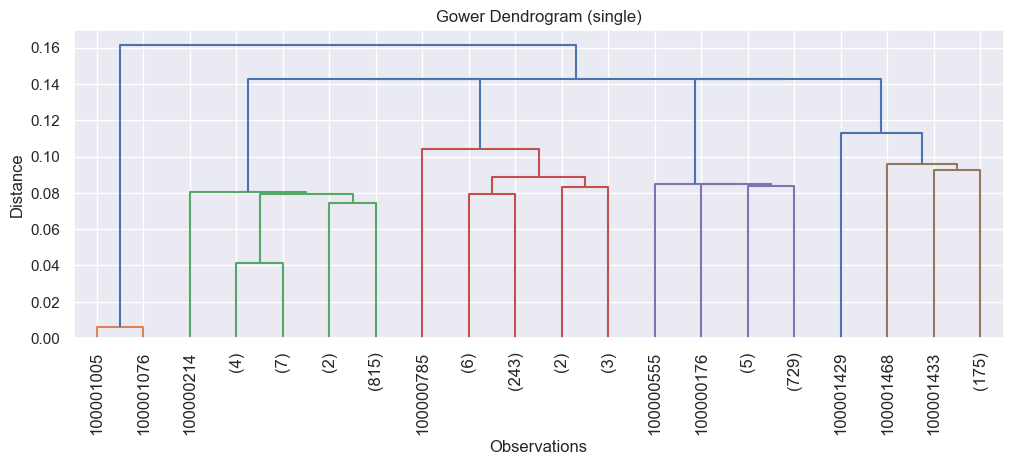

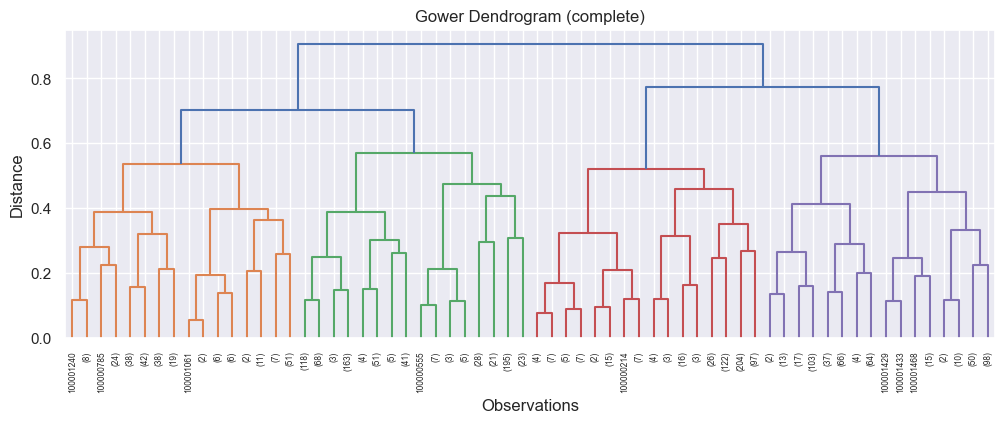

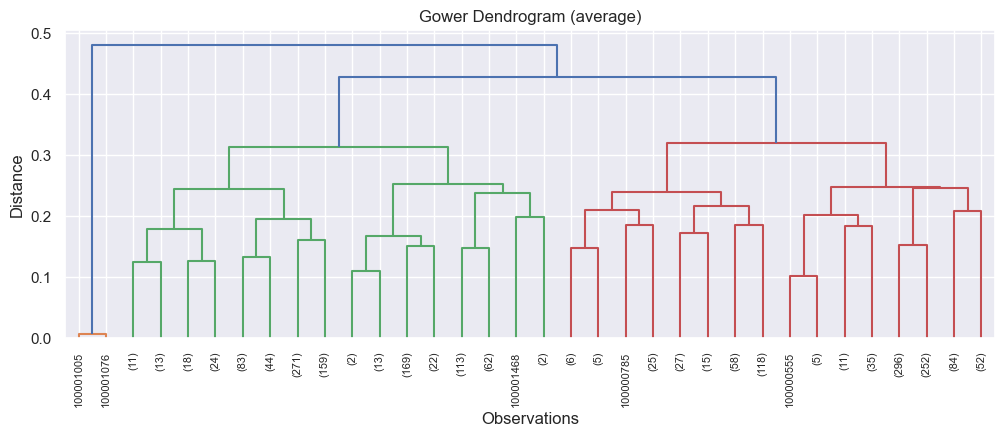

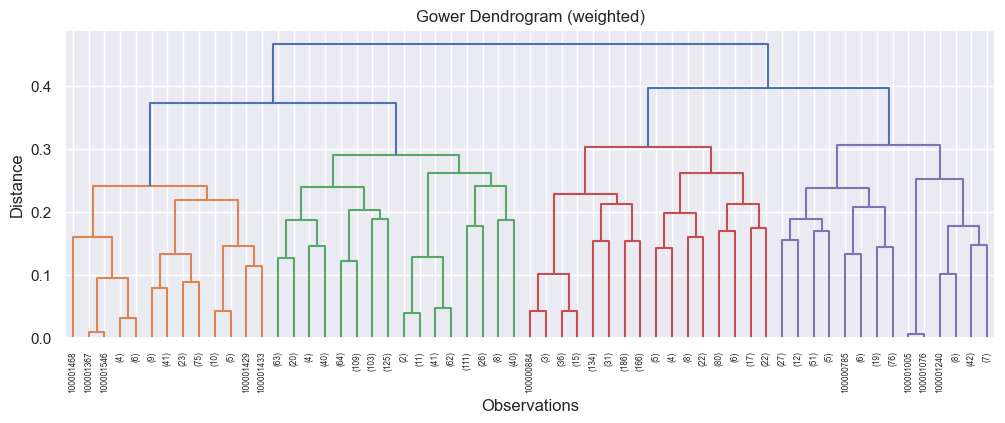

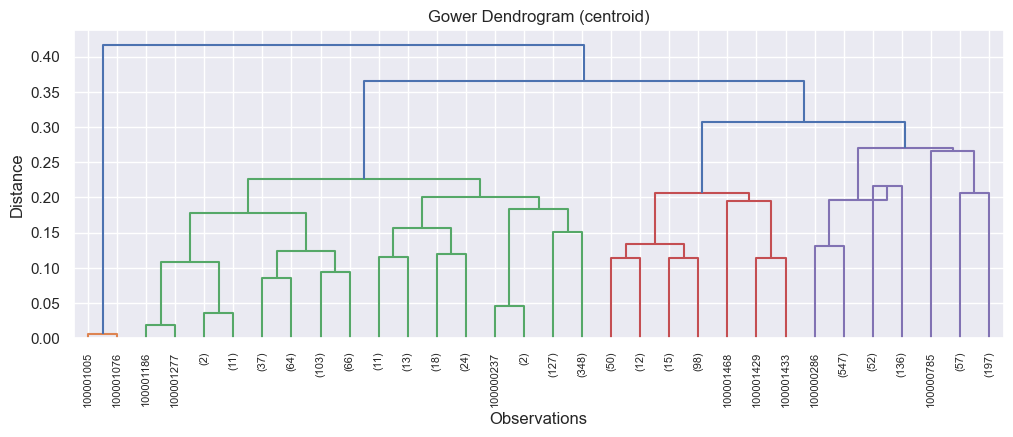

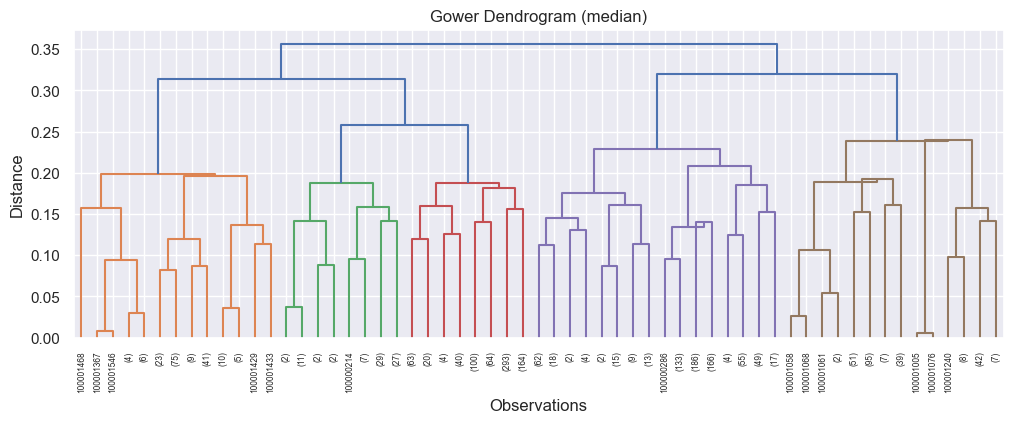

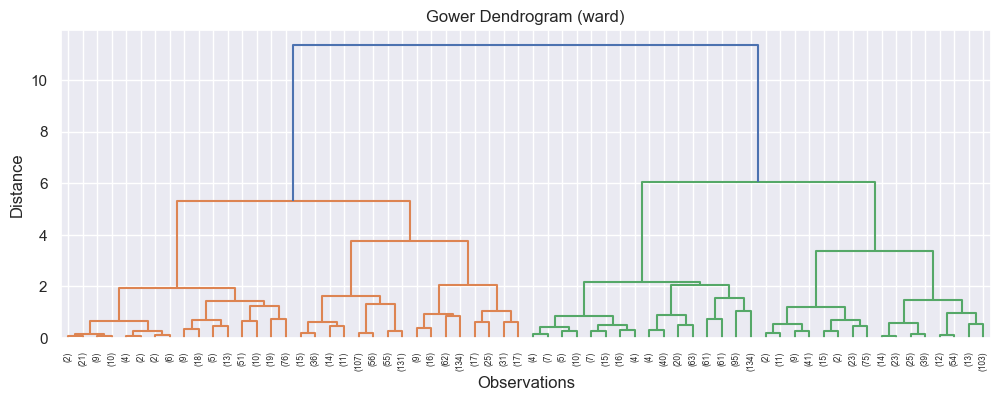

In [94]:
methods = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']
for method in methods:
    linkage_matrix = linkage(condensed_distance, method=method)

    plt.figure(figsize=(12,4))
    plt.title(f'Gower Dendrogram ({method})')
    plt.xlabel('Observations')
    plt.ylabel('Distance')
    dendrogram(linkage_matrix, truncate_mode='level', p=5, show_leaf_counts=True, labels=df_customers_gower.index, leaf_rotation=90)
    plt.show()

### 4 clusters

Sex  Marital status    Age  Education     Income  \
Cluster (gower)                                                      
0                1.00             1.0  33.19       1.26  116442.17   
1                0.37             0.0  36.33       0.79  100568.26   
2                0.00             0.0  40.30       0.84  145176.57   
3                0.00             1.0  33.97       1.27  122976.72   

                 Occupation  Settlement size  
Cluster (gower)                               
0                      0.74             0.57  
1                      0.36             0.07  
2                      1.26             1.51  
3                      0.93             0.92

Sex  Marital status   Age  Education    Income  Occupation  \
Cluster (gower)                                                               
0                1.0             1.0  29.0        1.0  110355.5         1.0   
1                0.0             0.0  35.0        1.0  102752.0         0.0   
2                0.0             0.0  37.0        1.0  136300.0         1.0   
3                0.0             1.0  31.0        1.0  115369.0         1.0   

                 Settlement size  
Cluster (gower)                   
0                            0.0  
1                            0.0  
2                            2.0  
3                            1.0

Sex  Marital status  Age  Education  Income  Occupation  \
Cluster (gower)                                                            
0                  1               1   26          1  102543           1   
1                  0               0   35          1   95228           0   
2                  0               0   36          1  126906           1   
3                  0               1   26          1   62263           1   

                 Settlement size  
Cluster (gower)                   
0                              0  
1                              0  
2                              2  
3                              0

Sex  Marital status        Age  Education  \
Cluster (gower)                                                   
0                1.000000             1.0  33.192935   1.262228   
1                0.367769             0.0  36.328512   0.791322   
2                0.000000             0.0  40.296367   0.837476   
3                0.000000             1.0  33.968872   1.268482   

                        Income  Occupation  Settlement size    #       %  
Cluster (gower)                                                           
0                116442.165761    0.741848         0.569293  736  0.3680  
1                100568.262397    0.361570         0.066116  484  0.2420  
2                145176.571702    1.261950         1.512428  523  0.2615  
3                122976.723735    0.933852         0.918288  257  0.1285

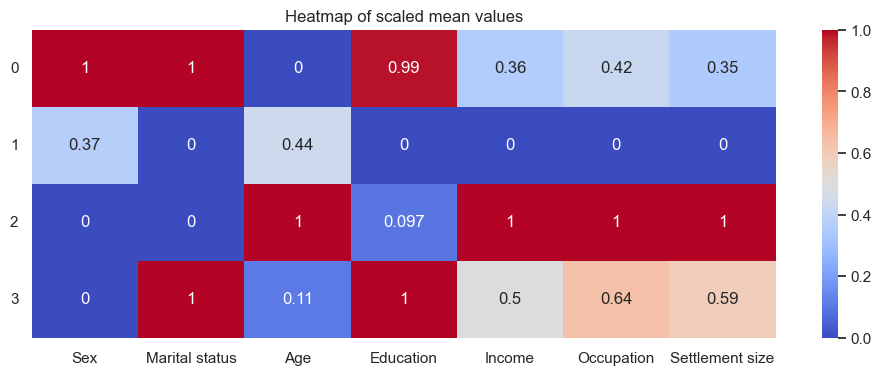

Sex  Marital status  \
Cluster (gower)                                                                
Younger married educated women with average car...  1.000000             1.0   
Unmarried men with unsuccessul careers in small...  0.367769             0.0   
Unmarried uneducated older men with successful ...  0.000000             0.0   
Younger married educated men with average careers   0.000000             1.0   

                                                          Age  Education  \
Cluster (gower)                                                            
Younger married educated women with average car...  33.192935   1.262228   
Unmarried men with unsuccessul careers in small...  36.328512   0.791322   
Unmarried uneducated older men with successful ...  40.296367   0.837476   
Younger married educated men with average careers   33.968872   1.268482   

                                                           Income  Occupation  \
Cluster (gower)                                                                 
Younger married educated women with average car...  116442.165761    0.741848   
Unmarried men with unsuccessul careers in small...  100568.262397    0.361570   
Unmarried uneducated older men with successful ...  145176.571702    1.261950   
Younger married educated men with average careers   122976.723735    0.933852   

                                                    Settlement size    #  \
Cluster (gower)                                                            
Younger married educated women with average car...         0.569293  736   
Unmarried men with unsuccessul careers in small...         0.066116  484   
Unmarried uneducated older men with successful ...         1.512428  523   
Younger married educated men with average careers          0.918288  257   

                                                         %  
Cluster (gower)                                             
Younger married educated women with average car...  0.3680  
Unmarried men with unsuccessul careers in small...  0.2420  
Unmarried uneducated older men with successful ...  0.2615  
Younger married educated men with average careers   0.1285

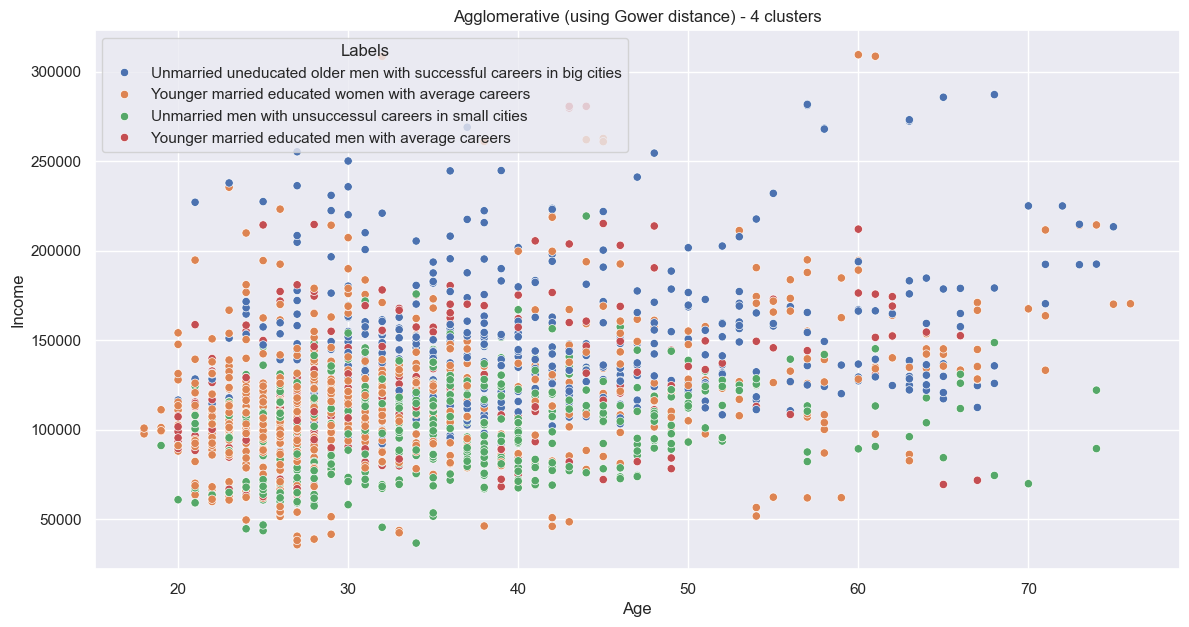

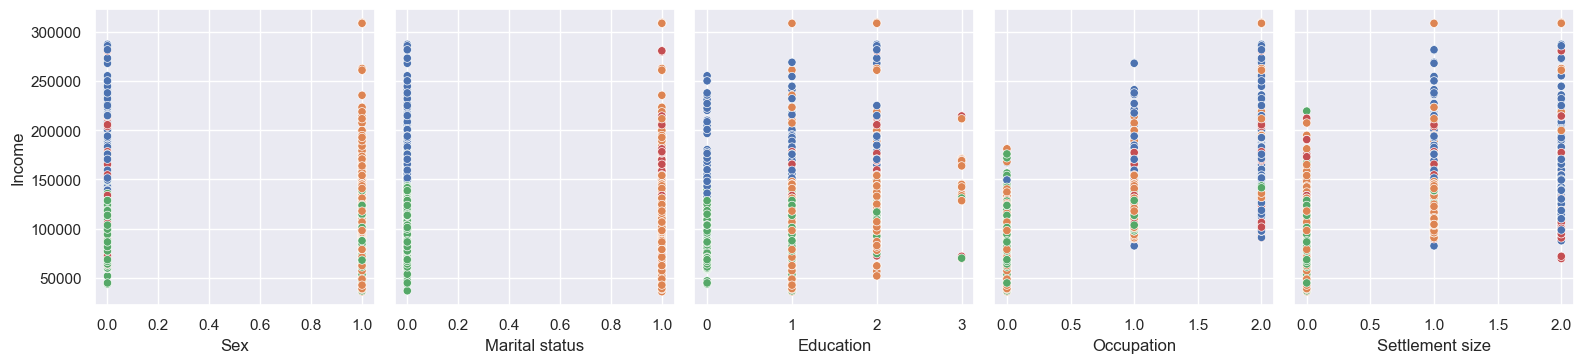

In [95]:
clustering_gower = AgglomerativeClustering(n_clusters=4, linkage='complete', metric='precomputed')
df_customers_gower_4 = df_customers.copy()
clusters_gower = clustering_gower.fit_predict(gower_distance_matrix)

df_customers_gower_4['Cluster (gower)'] = clusters_gower

display(df_customers_gower_4.groupby(['Cluster (gower)']).mean().round(2))
display(df_customers_gower_4.groupby(['Cluster (gower)']).median())
display(df_customers_gower_4.groupby(['Cluster (gower)']).agg(lambda x: x.mode()[0]))

df_customers_gower_4_analysis = df_customers_gower_4.groupby(['Cluster (gower)']).mean()
df_customers_gower_4_analysis['#'] = df_customers_gower_4[['Cluster (gower)','Sex']].groupby(['Cluster (gower)']).count()
df_customers_gower_4_analysis['%'] = df_customers_gower_4_analysis['#'] / df_customers_gower_4_analysis['#'].sum()

display(df_customers_gower_4_analysis)

scaler_gower_analysis_4 = MinMaxScaler()
df_customers_gower_4_analysis_scaled = pd.DataFrame(scaler_gower_analysis_4.fit_transform(df_customers_gower_4_analysis), columns=df_customers_gower_4_analysis.columns)
plt.figure(figsize=(12,4))
plt.title('Heatmap of scaled mean values')
s = sns.heatmap(df_customers_gower_4_analysis_scaled.drop(['#','%'], axis=1), annot=True, cmap='coolwarm', vmin=0, vmax=1)
s.set_yticklabels(s.get_yticklabels(), rotation=0)
plt.show()

mapping_gower_4 = { 0:'Younger married educated women with average careers',
                    1:'Unmarried men with unsuccessul careers in small cities',
                    2:'Unmarried uneducated older men with successful careers in big cities',
                    3:'Younger married educated men with average careers'}
df_customers_gower_4_analysis.rename(mapping_gower_4, inplace=True)
display(df_customers_gower_4_analysis)
df_customers_gower_4['Labels'] = df_customers_gower_4['Cluster (gower)'].map(mapping_gower_4)
plt.figure(figsize=(14, 7))
sns.scatterplot(data=df_customers_gower_4, x='Age', y='Income', hue=df_customers_gower_4['Labels'])
plt.title('Agglomerative (using Gower distance) - 4 clusters')
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(16,4), sharey=True)
for i, column in enumerate(df_customers_gower_4.columns.drop(['Age','Income','Cluster (gower)','Labels'])):
    sns.scatterplot(data=df_customers_gower_4, x=column, y='Income', hue=df_customers_gower_4['Labels'], ax=axes[i])
    axes[i].legend().remove()
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

## K-means

### Elbow

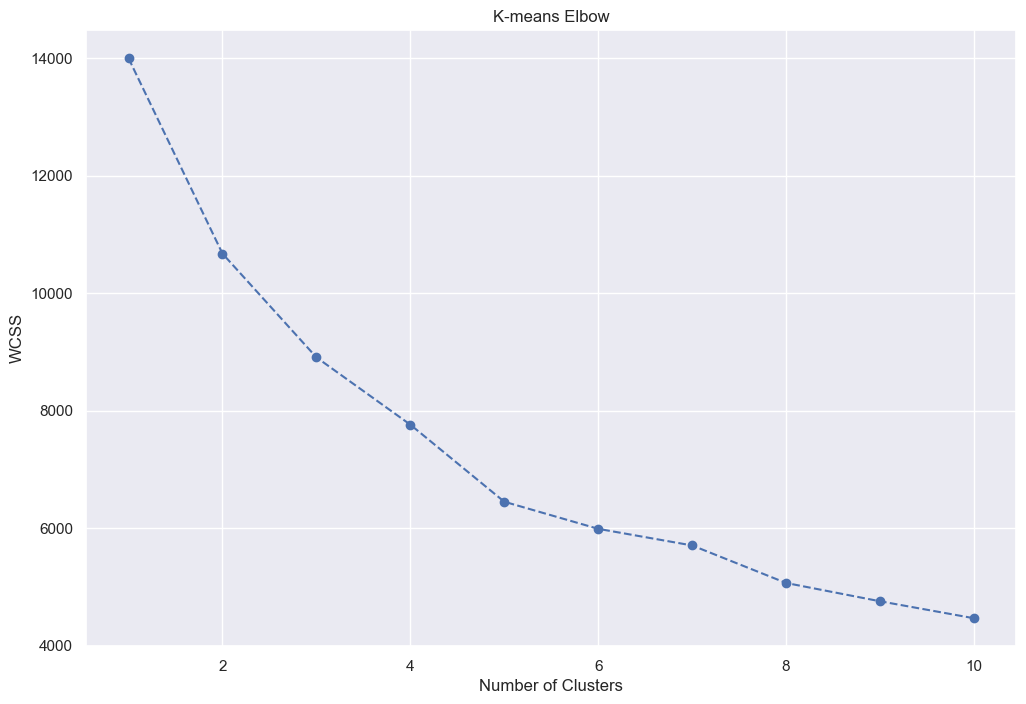

In [96]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(customers_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(12,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Elbow')
plt.show()

### 5 clusters

Sex  Marital status    Age  Education     Income  \
Cluster (K-means)                                                      
0                  0.03            0.00  35.42       0.62  100066.21   
1                  0.89            0.65  33.30       1.11   89360.08   
2                  0.75            0.98  27.92       1.00  119900.78   
3                  0.00            0.04  37.14       0.71  144048.62   
4                  0.48            0.68  55.65       2.14  161276.77   

                   Occupation  Settlement size  
Cluster (K-means)                               
0                        0.39             0.11  
1                        0.09             0.00  
2                        1.05             0.81  
3                        1.28             1.54  
4                        1.18             1.16

Sex  Marital status   Age  Education    Income  Occupation  \
Cluster (K-means)                                                               
0                  0.0             0.0  35.0        1.0  101197.5         0.0   
1                  1.0             1.0  31.0        1.0   87789.0         0.0   
2                  1.0             1.0  27.0        1.0  113118.0         1.0   
3                  0.0             0.0  36.0        1.0  138011.0         1.0   
4                  0.0             1.0  57.0        2.0  149464.5         1.0   

                   Settlement size  
Cluster (K-means)                   
0                              0.0  
1                              0.0  
2                              1.0  
3                              2.0  
4                              1.0

Sex  Marital status  Age  Education  Income  Occupation  \
Cluster (K-means)                                                            
0                    0               0   35          1   43684           0   
1                    1               1   26          1   35832           0   
2                    1               1   26          1  102543           1   
3                    0               0   36          1   88027           1   
4                    0               1   64          2   69487           1   

                   Settlement size  
Cluster (K-means)                   
0                                0  
1                                0  
2                                0  
3                                2  
4                                1

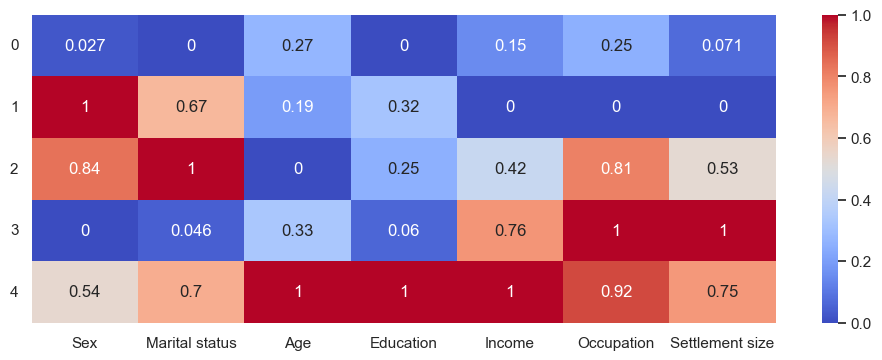

Sex  Marital status  \
Cluster (K-means)                                                              
Unmarried uneducated men with unsuccessful care...  0.028302        0.000000   
Young married women with unsuccessful careers i...  0.891705        0.652074   
Young married men with average careers              0.748582        0.979206   
Unmarried uneducated men with successful career...  0.004264        0.044776   
Older folk with successful careers in middle ci...  0.480000        0.684000   

                                                          Age  Education  \
Cluster (K-means)                                                          
Unmarried uneducated men with unsuccessful care...  35.418239   0.619497   
Young married women with unsuccessful careers i...  33.297235   1.108295   
Young married men with average careers              27.924386   1.003781   
Unmarried uneducated men with successful career...  37.142857   0.710021   
Older folk with successful careers in middle ci...  55.648000   2.136000   

                                                           Income  Occupation  \
Cluster (K-means)                                                               
Unmarried uneducated men with unsuccessful care...  100066.210692    0.393082   
Young married women with unsuccessful careers i...   89360.076037    0.094470   
Young married men with average careers              119900.778828    1.052930   
Unmarried uneducated men with successful career...  144048.624733    1.283582   
Older folk with successful careers in middle ci...  161276.772000    1.184000   

                                                    Settlement size    #  \
Cluster (K-means)                                                          
Unmarried uneducated men with unsuccessful care...         0.110063  318   
Young married women with unsuccessful careers i...         0.000000  434   
Young married men with average careers                     0.814745  529   
Unmarried uneducated men with successful career...         1.539446  469   
Older folk with successful careers in middle ci...         1.160000  250   

                                                         %  
Cluster (K-means)                                           
Unmarried uneducated men with unsuccessful care...  0.1590  
Young married women with unsuccessful careers i...  0.2170  
Young married men with average careers              0.2645  
Unmarried uneducated men with successful career...  0.2345  
Older folk with successful careers in middle ci...  0.1250

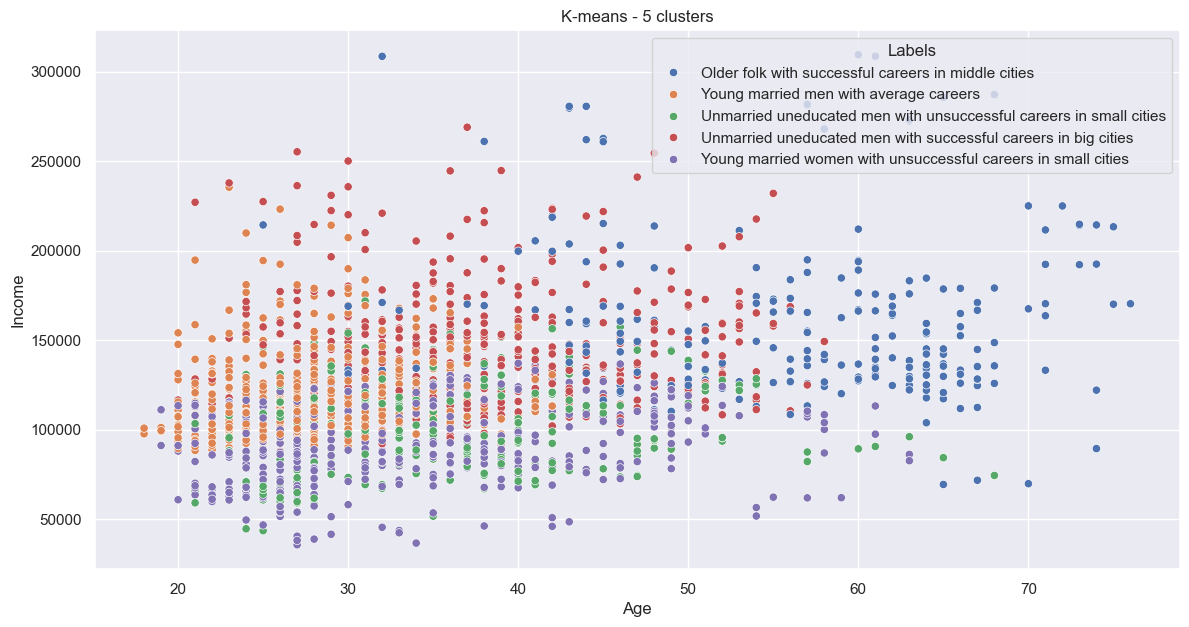

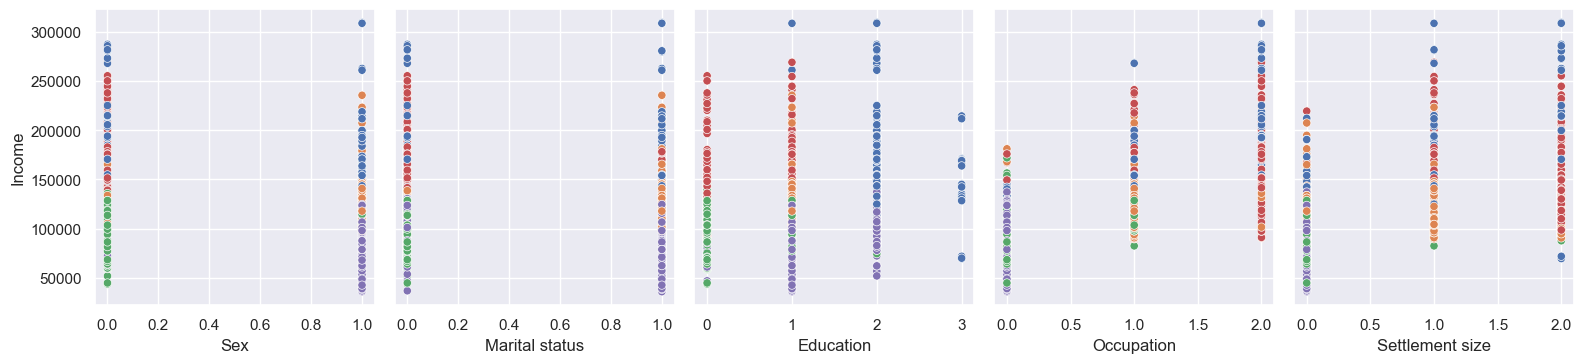

In [97]:
kmeans_5 = KMeans(n_clusters=5, init='k-means++', random_state=42)
kmeans_5.fit(customers_scaled)
clusters_kmeans_5 = kmeans_5.labels_

df_customers_kmeans_5 = df_customers.copy()
df_customers_kmeans_5['Cluster (K-means)'] = clusters_kmeans_5

display(df_customers_kmeans_5.groupby(['Cluster (K-means)']).mean().round(2))
display(df_customers_kmeans_5.groupby(['Cluster (K-means)']).median())
display(df_customers_kmeans_5.groupby(['Cluster (K-means)']).agg(lambda x: x.mode()[0]))

df_customers_kmeans_5_analysis = df_customers_kmeans_5.groupby(['Cluster (K-means)']).mean()
df_customers_kmeans_5_analysis['#'] = df_customers_kmeans_5[['Cluster (K-means)','Sex']].groupby(['Cluster (K-means)']).count()
df_customers_kmeans_5_analysis['%'] = df_customers_kmeans_5_analysis['#'] / df_customers_kmeans_5_analysis['#'].sum()

scaler_analysis_5 = MinMaxScaler()
df_customers_analysis_5_scaled = pd.DataFrame(scaler_analysis_5.fit_transform(df_customers_kmeans_5_analysis), columns=df_customers_kmeans_5_analysis.columns)
plt.figure(figsize=(12,4))
s = sns.heatmap(df_customers_analysis_5_scaled.drop(['#','%'], axis=1), annot=True, cmap='coolwarm', vmin=0, vmax=1)
s.set_yticklabels(s.get_yticklabels(), rotation=0)
plt.show()

mapping_kmeans_5 = {0:'Unmarried uneducated men with unsuccessful careers in small cities',
                    1:'Young married women with unsuccessful careers in small cities',
                    2:'Young married men with average careers',
                    3:'Unmarried uneducated men with successful careers in big cities',
                    4:'Older folk with successful careers in middle cities'}
df_customers_kmeans_5_analysis.rename(mapping_kmeans_5, inplace=True)
df_customers_kmeans_5['Labels'] = df_customers_kmeans_5['Cluster (K-means)'].map(mapping_kmeans_5)

display(df_customers_kmeans_5_analysis)

plt.figure(figsize=(14, 7))
sns.scatterplot(data=df_customers_kmeans_5, x='Age', y='Income', hue=df_customers_kmeans_5['Labels'])
plt.title('K-means - 5 clusters')
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(16,4), sharey=True)
for i, column in enumerate(df_customers_kmeans_5.columns.drop(['Age','Income','Cluster (K-means)','Labels'])):
    sns.scatterplot(data=df_customers_kmeans_5, x=column, y='Income', hue=df_customers_kmeans_5['Labels'], ax=axes[i])
    axes[i].legend().remove()
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

## K-modes

### Elbow

Assessing 1 clusters for Cao
Assessing 2 clusters for Cao
Assessing 3 clusters for Cao
Assessing 4 clusters for Cao
Assessing 5 clusters for Cao
Assessing 6 clusters for Cao
Assessing 7 clusters for Cao
Assessing 8 clusters for Cao
Assessing 9 clusters for Cao
Assessing 10 clusters for Cao
Assessing 1 clusters for Huang
Assessing 2 clusters for Huang
Assessing 3 clusters for Huang
Assessing 4 clusters for Huang
Assessing 5 clusters for Huang
Assessing 6 clusters for Huang
Assessing 7 clusters for Huang
Assessing 8 clusters for Huang
Assessing 9 clusters for Huang
Assessing 10 clusters for Huang


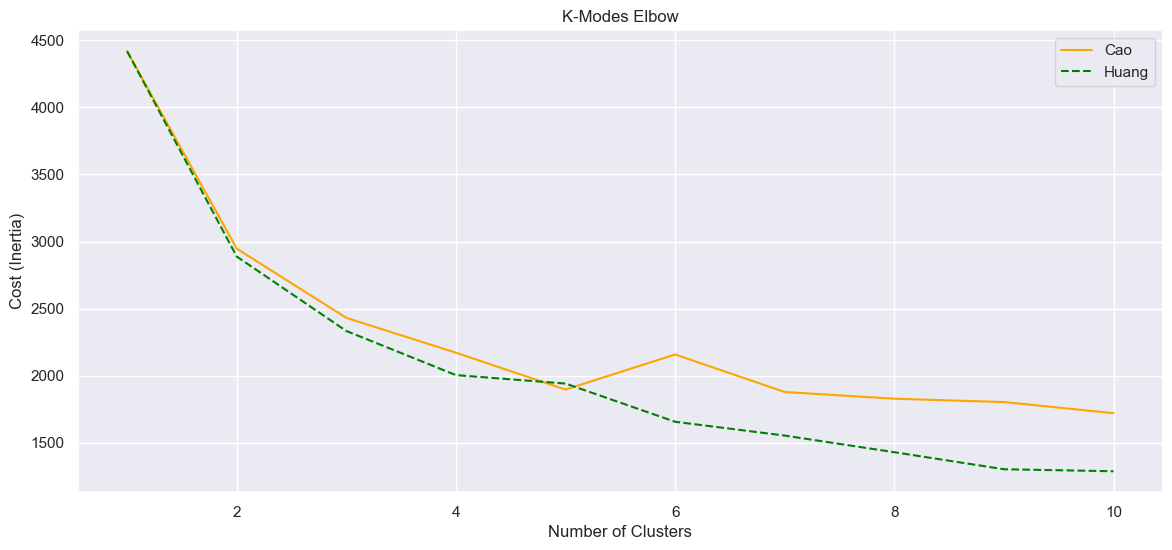

In [98]:
kmodes_costs = {'Cao': [], 'Huang': []}
kmodes_methods = ['Cao','Huang']
kmodes_cluster_range = range(1,11)

for init_method in kmodes_methods:
    for n_clusters in kmodes_cluster_range:
        print(f'Assessing {n_clusters} clusters for {init_method}')
        kmodes = KModes(n_clusters=n_clusters, init=init_method, n_init=10, verbose=0, random_state=42)
        kmodes_clusters = kmodes.fit_predict(df_customers_cats)
        kmodes_costs[init_method].append(kmodes.cost_)

plt.figure(figsize=(14,6))
styles = {'Cao': {'colour': 'orange', 'linestyle': '-'},
          'Huang': {'colour': 'green', 'linestyle': '--'}}
for init_method in kmodes_methods:
    plt.plot(kmodes_cluster_range, kmodes_costs[init_method], label=init_method, color=styles[init_method]['colour'], linestyle=styles[init_method]['linestyle'])
plt.xlabel('Number of Clusters')
plt.ylabel('Cost (Inertia)')
plt.title('K-Modes Elbow')
plt.legend()
plt.show()

### 3 clusters

In [99]:
kmodes_3 = KModes(n_clusters=3, init='Huang', n_init=10, verbose=0, random_state=42)
clusters_kmodes_3 = kmodes_3.fit_predict(df_customers_cats)

Sex  Marital status    Age  Education     Income  \
Cluster (K-modes)                                                      
0                  0.20            0.15  37.41       0.89  107976.01   
1                  0.89            0.93  33.38       1.23  117215.77   
2                  0.00            0.14  38.58       0.86  141677.38   

                   Occupation  Settlement size  
Cluster (K-modes)                               
0                        0.48             0.23  
1                        0.79             0.54  
2                        1.21             1.64

Sex  Marital status   Age  Education    Income  Occupation  \
Cluster (K-modes)                                                               
0                  0.0             0.0  36.0        1.0  103454.5         0.0   
1                  1.0             1.0  29.0        1.0  111731.0         1.0   
2                  0.0             0.0  36.0        1.0  133117.0         1.0   

                   Settlement size  
Cluster (K-modes)                   
0                              0.0  
1                              0.0  
2                              2.0

Sex  Marital status  Age  Education  Income  Occupation  \
Cluster (K-modes)                                                            
0                    0               0   40          1   83687           0   
1                    1               1   26          1  102543           1   
2                    0               0   36          1   82398           1   

                   Settlement size  
Cluster (K-modes)                   
0                                0  
1                                0  
2                                2

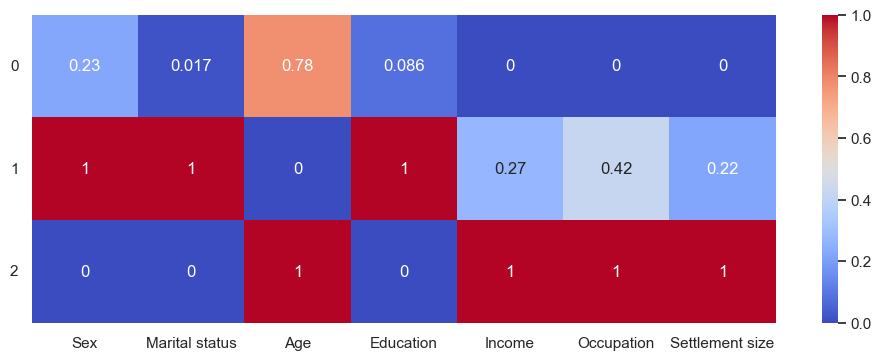

Sex  Marital status  \
Cluster (K-modes)                                                              
Unmarried men with unsuccessul careers in small...  0.200692        0.148789   
Younger married women with high education and a...  0.888641        0.930958   
Unmarried men with successful careers in big ci...  0.000000        0.135496   

                                                          Age  Education  \
Cluster (K-modes)                                                          
Unmarried men with unsuccessul careers in small...  37.413495   0.892734   
Younger married women with high education and a...  33.379733   1.234967   
Unmarried men with successful careers in big ci...  38.583969   0.860687   

                                                           Income  Occupation  \
Cluster (K-modes)                                                               
Unmarried men with unsuccessul careers in small...  107976.008651    0.480969   
Younger married women with high education and a...  117215.768374    0.788419   
Unmarried men with successful careers in big ci...  141677.375954    1.211832   

                                                    Settlement size    #  \
Cluster (K-modes)                                                          
Unmarried men with unsuccessul careers in small...         0.226644  578   
Younger married women with high education and a...         0.541203  898   
Unmarried men with successful careers in big ci...         1.643130  524   

                                                        %  
Cluster (K-modes)                                          
Unmarried men with unsuccessul careers in small...  0.289  
Younger married women with high education and a...  0.449  
Unmarried men with successful careers in big ci...  0.262

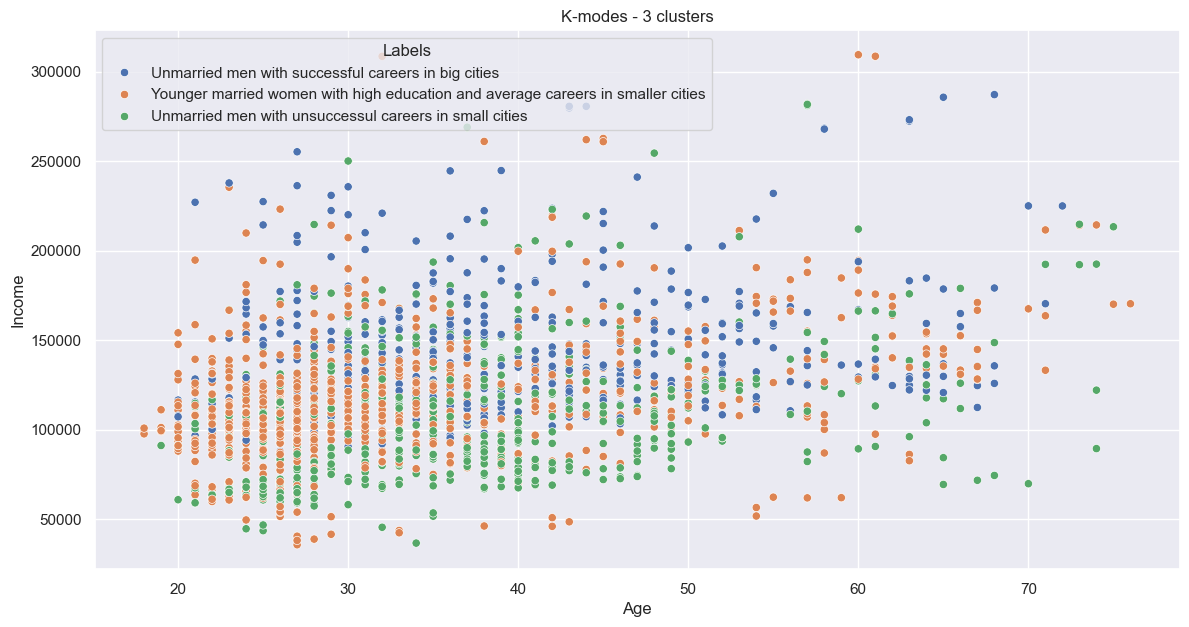

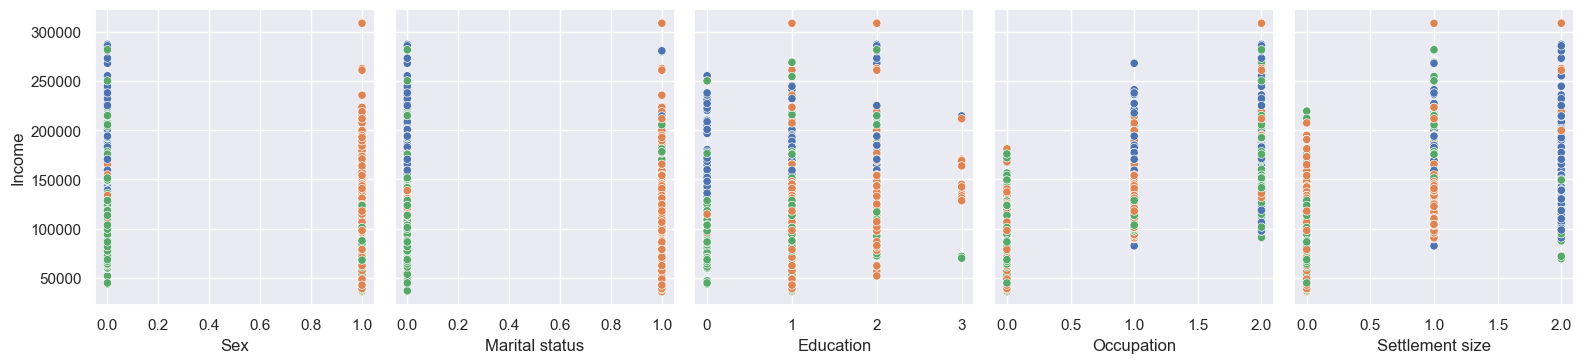

In [100]:
df_customers_kmodes_3 = df_customers.copy()
df_customers_kmodes_3['Cluster (K-modes)'] = clusters_kmodes_3

display(df_customers_kmodes_3.groupby(['Cluster (K-modes)']).mean().round(2))
display(df_customers_kmodes_3.groupby(['Cluster (K-modes)']).median())
display(df_customers_kmodes_3.groupby(['Cluster (K-modes)']).agg(lambda x: x.mode()[0]))

df_customers_kmodes_3_analysis = df_customers_kmodes_3.groupby(['Cluster (K-modes)']).mean()
df_customers_kmodes_3_analysis['#'] = df_customers_kmodes_3[['Cluster (K-modes)','Sex']].groupby(['Cluster (K-modes)']).count()
df_customers_kmodes_3_analysis['%'] = df_customers_kmodes_3_analysis['#'] / df_customers_kmodes_3_analysis['#'].sum()

scaler_analysis_kmodes_3 = MinMaxScaler()
df_customers_kmodes_3_analysis_scaled = pd.DataFrame(scaler_analysis_kmodes_3.fit_transform(df_customers_kmodes_3_analysis), columns=df_customers_kmodes_3_analysis.columns)
plt.figure(figsize=(12,4))
s = sns.heatmap(df_customers_kmodes_3_analysis_scaled.drop(['#','%'], axis=1), annot=True, cmap='coolwarm', vmin=0, vmax=1)
s.set_yticklabels(s.get_yticklabels(), rotation=0)
plt.show()

mapping_kmodes_3 = {0:'Unmarried men with unsuccessul careers in small cities',
                    1:'Younger married women with high education and average careers in smaller cities',
                    2:'Unmarried men with successful careers in big cities'}
df_customers_kmodes_3_analysis.rename(mapping_kmodes_3, inplace=True)
df_customers_kmodes_3['Labels'] = df_customers_kmodes_3['Cluster (K-modes)'].map(mapping_kmodes_3)

display(df_customers_kmodes_3_analysis)

plt.figure(figsize=(14, 7))
sns.scatterplot(data=df_customers_kmodes_3, x='Age', y='Income', hue=df_customers_kmodes_3['Labels'])
plt.title('K-modes - 3 clusters')
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(16,4), sharey=True)
for i, column in enumerate(df_customers_kmodes_3.columns.drop(['Age','Income','Cluster (K-modes)','Labels'])):
    sns.scatterplot(data=df_customers_kmodes_3, x=column, y='Income', hue=df_customers_kmodes_3['Labels'], ax=axes[i])
    axes[i].legend().remove()
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

## K-prototypes

### Elbow

Assessing 1 clusters for Cao
Assessing 2 clusters for Cao
Assessing 3 clusters for Cao
Assessing 4 clusters for Cao
Assessing 5 clusters for Cao
Assessing 6 clusters for Cao
Assessing 7 clusters for Cao
Assessing 8 clusters for Cao
Assessing 9 clusters for Cao
Assessing 10 clusters for Cao
Assessing 1 clusters for Huang
Assessing 2 clusters for Huang
Assessing 3 clusters for Huang
Assessing 4 clusters for Huang
Assessing 5 clusters for Huang
Assessing 6 clusters for Huang
Assessing 7 clusters for Huang
Assessing 8 clusters for Huang
Assessing 9 clusters for Huang
Assessing 10 clusters for Huang


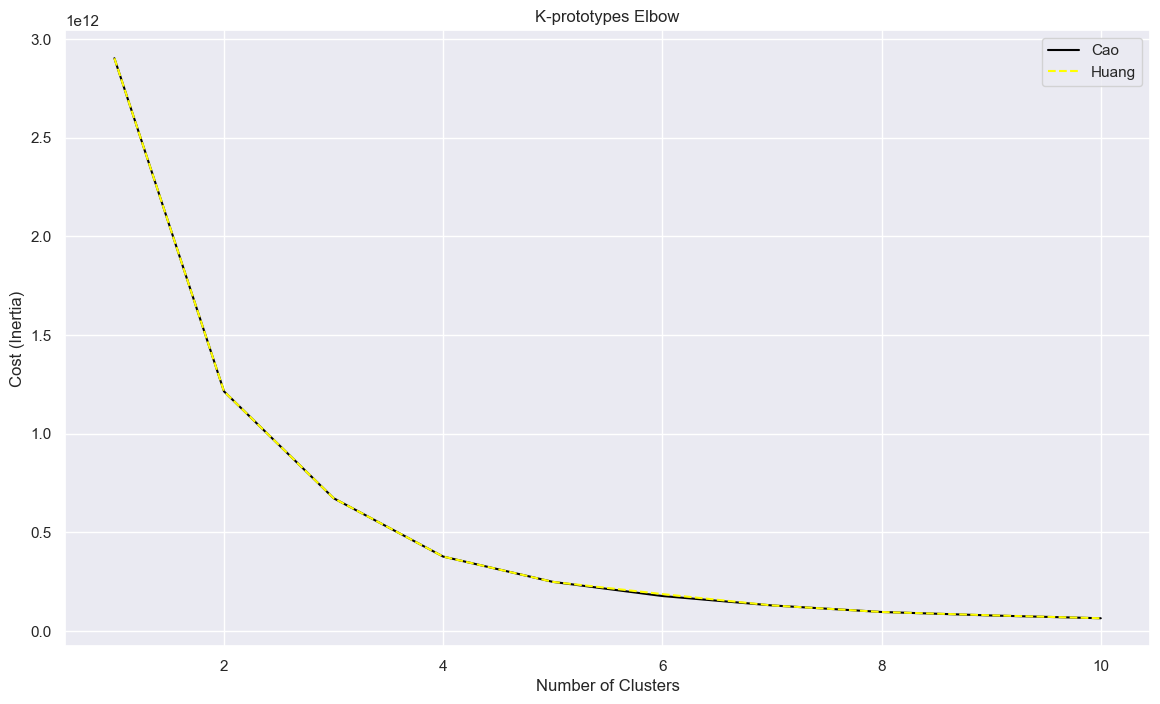

In [101]:
kprot_costs = {'Cao': [], 'Huang': []}
kprot_methods = ['Cao','Huang']
kprot_cluster_range = range(1,11)

for init_method in kprot_methods:
    for n_clusters in kprot_cluster_range:
        print(f'Assessing {n_clusters} clusters for {init_method}')
        kproto = KPrototypes(n_clusters=n_clusters, init=init_method, n_init=10, verbose=0, random_state=42)
        kproto.fit_predict(df_customers, categorical=[0,1,3,5,6])
        kprot_costs[init_method].append(kproto.cost_)

plt.figure(figsize=(14,8))
styles = {'Cao': {'colour': 'black', 'linestyle': '-'},
          'Huang': {'colour': 'yellow', 'linestyle': '--'}}
for init_method in kprot_methods:
    plt.plot(kprot_cluster_range, kprot_costs[init_method], label=init_method, color=styles[init_method]['colour'], linestyle=styles[init_method]['linestyle'])
plt.xlabel('Number of Clusters')
plt.ylabel('Cost (Inertia)')
plt.title('K-prototypes Elbow')
plt.legend()
plt.show()

### 3 clusters

In [102]:
kprot_3 = KPrototypes(n_clusters=3, init='Cao', n_init=10, verbose=0, random_state=42)
clusters_kprot_3 = kprot_3.fit_predict(df_customers, categorical=[0,1,3,5,6])

Sex  Marital status    Age  Education     Income  \
Cluster (K-prototypes)                                                      
0                       0.57            0.55  31.96       0.92   90790.18   
1                       0.38            0.45  37.90       1.08  132116.44   
2                       0.30            0.46  43.93       1.36  199404.45   

                        Occupation  Settlement size  
Cluster (K-prototypes)                               
0                             0.43             0.37  
1                             1.00             0.95  
2                             1.59             1.38

Sex  Marital status   Age  Education    Income  \
Cluster (K-prototypes)                                                   
0                       1.0             1.0  29.0        1.0   94884.0   
1                       0.0             0.0  35.0        1.0  128609.5   
2                       0.0             0.0  42.0        1.0  188594.0   

                        Occupation  Settlement size  
Cluster (K-prototypes)                               
0                              0.0              0.0  
1                              1.0              1.0  
2                              2.0              1.0

Sex  Marital status  Age  Education  Income  \
Cluster (K-prototypes)                                                
0                         1               1   26          1   69487   
1                         0               0   36          1  112227   
2                         0               0   30          1  166712   

                        Occupation  Settlement size  
Cluster (K-prototypes)                               
0                                0                0  
1                                1                1  
2                                2                2

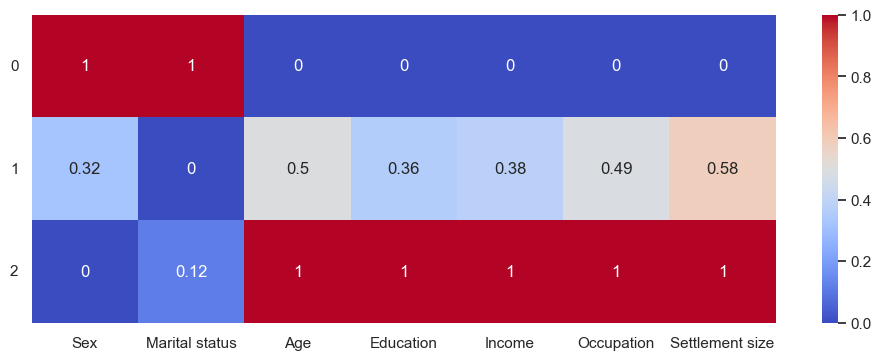

Sex  Marital status  \
Cluster (K-prototypes)                                                         
Unmarried men with below-average careers in sma...  0.569335        0.554679   
Very average                                        0.384444        0.447778   
Older men with successul careers in bigger cities   0.295775        0.460094   

                                                          Age  Education  \
Cluster (K-prototypes)                                                     
Unmarried men with below-average careers in sma...  31.961669   0.921082   
Very average                                        37.900000   1.077778   
Older men with successul careers in bigger cities   43.934272   1.356808   

                                                           Income  Occupation  \
Cluster (K-prototypes)                                                          
Unmarried men with below-average careers in sma...   90790.183766    0.432920   
Very average                                        132116.442222    0.997778   
Older men with successul careers in bigger cities   199404.446009    1.591549   

                                                    Settlement size    #  \
Cluster (K-prototypes)                                                     
Unmarried men with below-average careers in sma...         0.367531  887   
Very average                                               0.954444  900   
Older men with successul careers in bigger cities          1.375587  213   

                                                         %  
Cluster (K-prototypes)                                      
Unmarried men with below-average careers in sma...  0.4435  
Very average                                        0.4500  
Older men with successul careers in bigger cities   0.1065

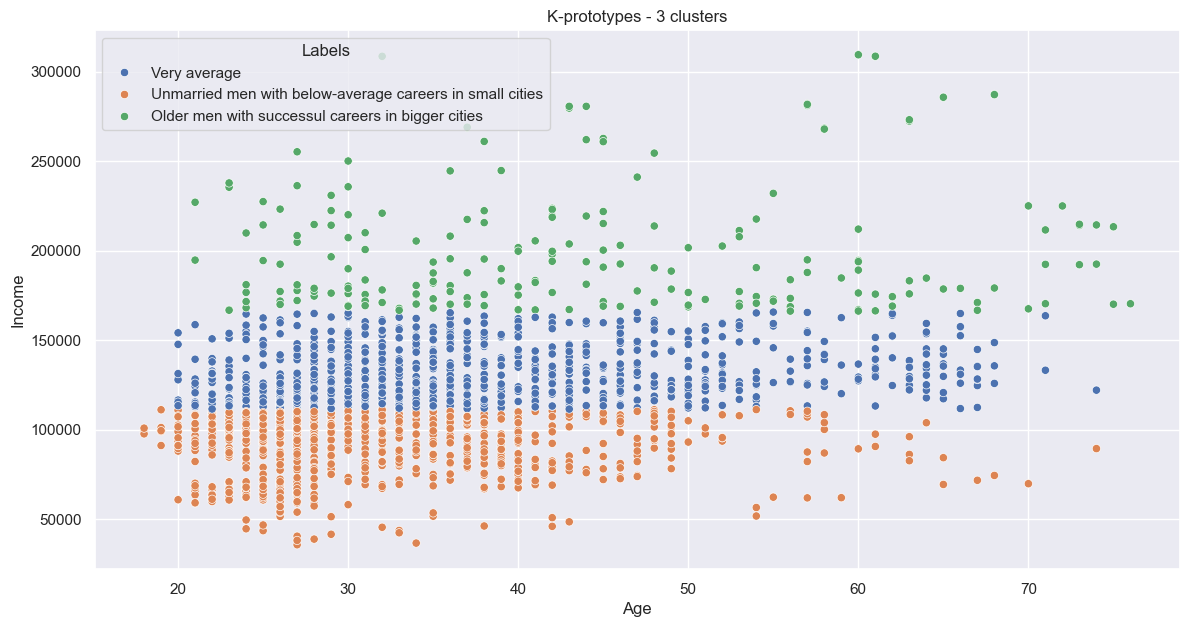

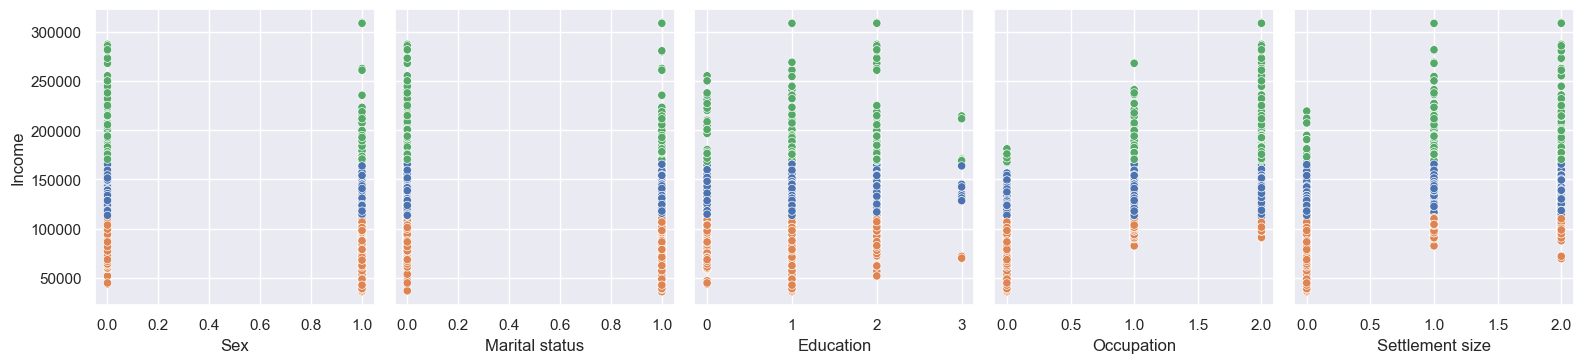

In [103]:
df_customers_kprot_3 = df_customers.copy()
df_customers_kprot_3['Cluster (K-prototypes)'] = clusters_kprot_3

display(df_customers_kprot_3.groupby(['Cluster (K-prototypes)']).mean().round(2))
display(df_customers_kprot_3.groupby(['Cluster (K-prototypes)']).median())
display(df_customers_kprot_3.groupby(['Cluster (K-prototypes)']).agg(lambda x: x.mode()[0]))

df_customers_kprot_3_analysis = df_customers_kprot_3.groupby(['Cluster (K-prototypes)']).mean()
df_customers_kprot_3_analysis['#'] = df_customers_kprot_3[['Cluster (K-prototypes)','Sex']].groupby(['Cluster (K-prototypes)']).count()
df_customers_kprot_3_analysis['%'] = df_customers_kprot_3_analysis['#'] / df_customers_kprot_3_analysis['#'].sum()
df_customers_kprot_3_analysis

scaler_kprot_analysis_3 = MinMaxScaler()
df_customers_kprot_3_analysis_scaled = pd.DataFrame(scaler_kprot_analysis_3.fit_transform(df_customers_kprot_3_analysis), columns=df_customers_kprot_3_analysis.columns)
plt.figure(figsize=(12,4))
s = sns.heatmap(df_customers_kprot_3_analysis_scaled.drop(['#','%'], axis=1), annot=True, cmap='coolwarm', vmin=0, vmax=1)
s.set_yticklabels(s.get_yticklabels(), rotation=0)
plt.show()

mapping_kprot_3 = { 0:'Unmarried men with below-average careers in small cities',
                    1:'Very average',
                    2:'Older men with successul careers in bigger cities'}
df_customers_kprot_3_analysis.rename(mapping_kprot_3, inplace=True)
df_customers_kprot_3['Labels'] = df_customers_kprot_3['Cluster (K-prototypes)'].map(mapping_kprot_3)
display(df_customers_kprot_3_analysis)

plt.figure(figsize=(14, 7))
sns.scatterplot(data=df_customers_kprot_3, x='Age', y='Income', hue=df_customers_kprot_3['Labels'])
plt.title('K-prototypes - 3 clusters')
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(16,4), sharey=True)
for i, column in enumerate(df_customers_kprot_3.columns.drop(['Age','Income','Cluster (K-prototypes)','Labels'])):
    sns.scatterplot(data=df_customers_kprot_3, x=column, y='Income', hue=df_customers_kprot_3['Labels'], ax=axes[i])
    axes[i].legend().remove()
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

## Dimensionality reduction

### FAMD

c:\Users\jgibb\miniconda3\Lib\site-packages\prince\pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[np.float64(-0.5989574275355469), np.float64(-1.3162446581088183), np.float64(-0.6031169040907409), np.float64(-0.21213203435596423), np.float64(-1.1219402836158436), np.float64(-1.1141139977578596), np.float64(-0.8895223437328599), np.float64(-1.1795126112085448), np.float64(-0.5634713834792323), np.float64(-1.1118677978968543), np.float64(-0.8246211251235323), np.float64(-0.7640353394968064), np.float64(-1.1651180197731044), np.float64(-1.0688779163215976)]'. Picking the first and converting the rest.
  X = self.scaler_.transform(X.to_numpy())
c:\Users\jgibb\miniconda3\Lib\site-packages\prince\pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[np.float64(-0.5989574275355469), np.float64(-1.3162446581088183), np.float64(-0.6031169040907409), np.float64(-0.21213203435596423), np.float64(-1.1219402836158436), np.

alt.Chart(...)

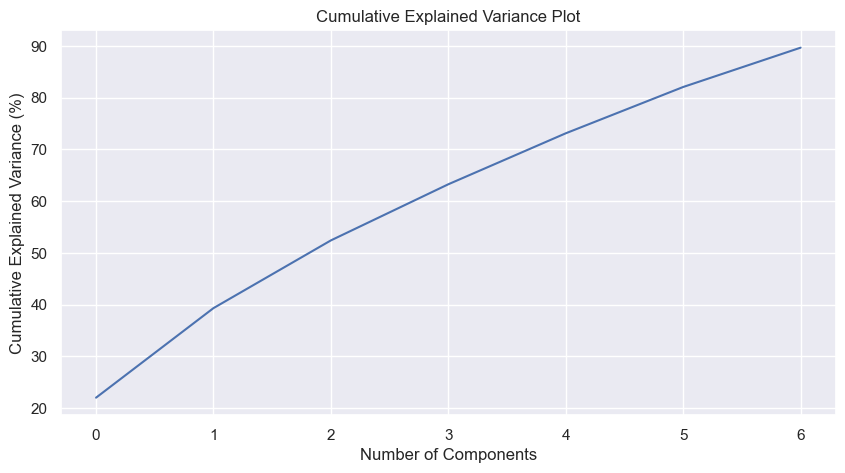

In [104]:
df_customers_famd = df_customers.copy()

for col in ['Sex', 'Marital status', 'Education', 'Occupation', 'Settlement size']:
    df_customers_famd[col] = df_customers_famd[col].astype('category')
for col in ['Age', 'Income']:
    df_customers_famd[col] = df_customers_famd[col].astype('float32')

famd = FAMD(n_components=len(df_customers_famd.columns), random_state=42)
famd.fit_transform(df_customers_famd)

display(famd.scree_plot())

plt.figure(figsize=(10, 5))
plt.plot(range(0, len(famd.cumulative_percentage_of_variance_)), famd.cumulative_percentage_of_variance_)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Cumulative Explained Variance Plot')
plt.show()

### Multidimenional scaling

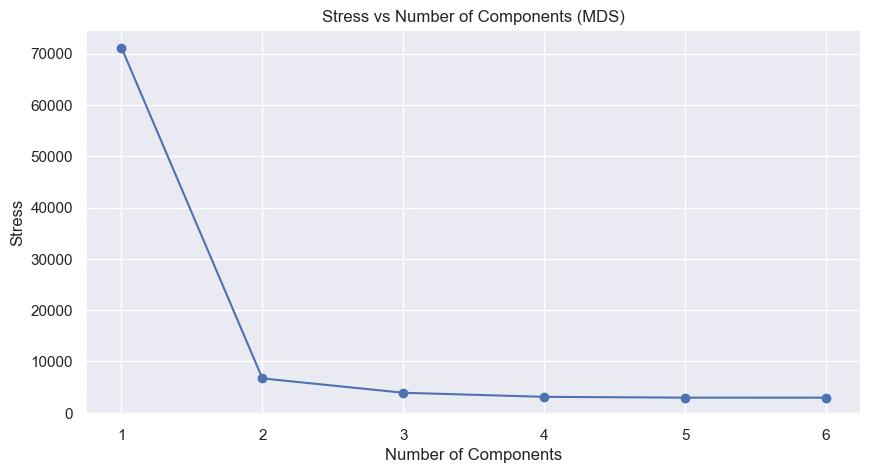

In [105]:
stress_values = []
for n_components in range(1,len(df_customers.columns)):
    mds = MDS(n_components=n_components, dissimilarity="precomputed", random_state=42)
    mds.fit(gower_distance_matrix)
    stress_values.append(mds.stress_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(stress_values)+1), stress_values, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Stress')
plt.title('Stress vs Number of Components (MDS)')
plt.show()

In [106]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
mds_fit = mds.fit_transform(gower_distance_matrix)

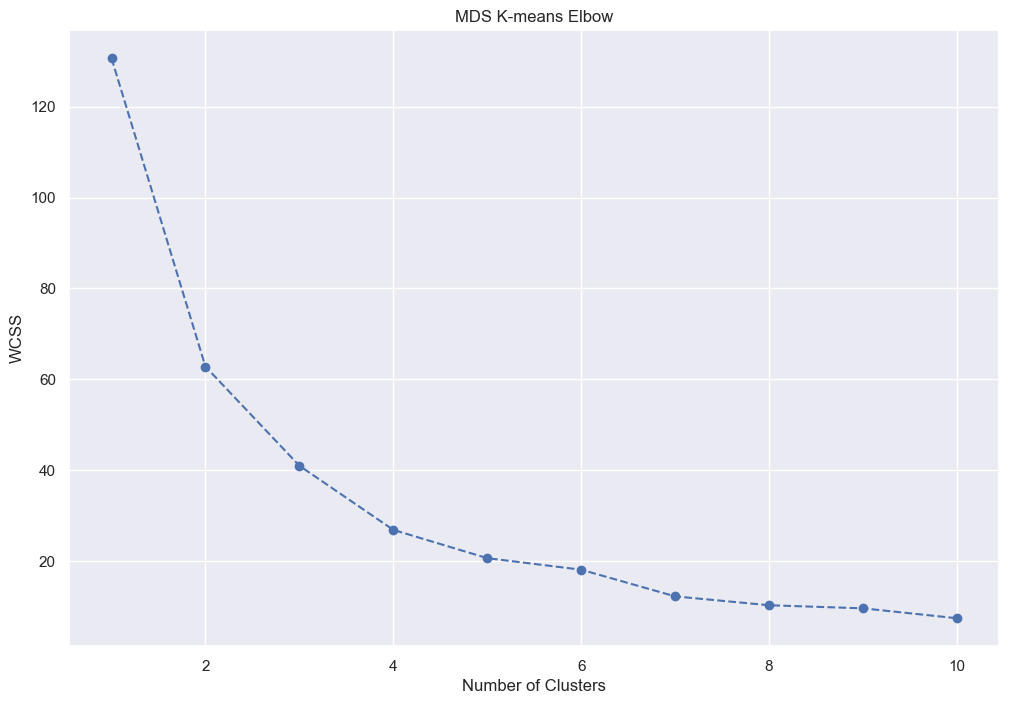

In [107]:
wcss = []
for i in range(1,11):
    kmeans_mds = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_mds.fit(mds_fit)
    wcss.append(kmeans_mds.inertia_)

plt.figure(figsize=(12,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('MDS K-means Elbow')
plt.show()

In [108]:
mds_kmeans_4 = KMeans(n_clusters=4, init='k-means++', random_state=42)
mds_kmeans_4.fit(mds_fit)
clusters_mds_kmeans_4 = mds_kmeans_4.labels_

Sex  Marital status    Age  Education     Income  \
Cluster (MDS K-means)                                                      
0                      0.00            0.00  40.10       0.83  145351.49   
1                      0.97            1.00  31.12       1.17  105420.52   
2                      0.49            0.99  37.24       1.43  143091.81   
3                      0.33            0.09  36.00       0.82   97509.27   

                       Occupation  Settlement size  
Cluster (MDS K-means)                               
0                            1.24             1.51  
1                            0.58             0.23  
2                            1.24             1.42  
3                            0.32             0.03

Sex  Marital status   Age  Education    Income  \
Cluster (MDS K-means)                                                   
0                      0.0             0.0  37.0        1.0  136750.5   
1                      1.0             1.0  28.0        1.0  106079.0   
2                      0.0             1.0  33.0        1.0  135201.0   
3                      0.0             0.0  35.0        1.0   97241.0   

                       Occupation  Settlement size  
Cluster (MDS K-means)                               
0                             1.0              2.0  
1                             1.0              0.0  
2                             1.0              2.0  
3                             0.0              0.0

Sex  Marital status  Age  Education  Income  \
Cluster (MDS K-means)                                                
0                        0               0   36          1  126906   
1                        1               1   26          1  102543   
2                        0               1   26          1  166712   
3                        0               0   35          1   83687   

                       Occupation  Settlement size  
Cluster (MDS K-means)                               
0                               1                2  
1                               1                0  
2                               1                2  
3                               0                0

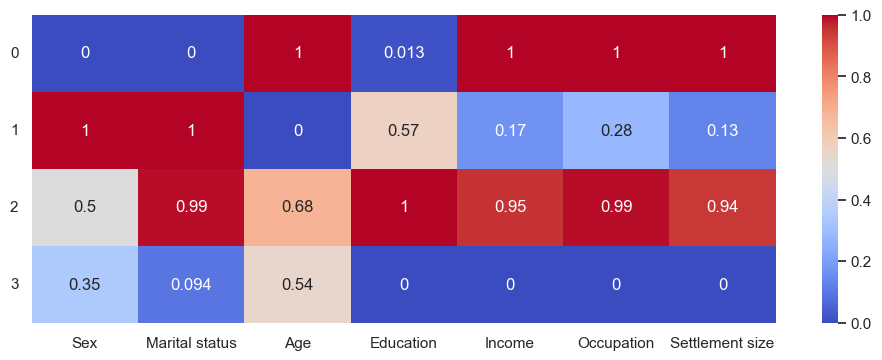

Sex  Marital status  \
Cluster (MDS K-means)                                                          
Unmarried uneducated older men with successful ...  0.000000        0.000000   
Younger married women with average careers in s...  0.968858        1.000000   
Educated married folk with successful careers i...  0.486486        0.989189   
Unmarried men with unsuccessful careers in smal...  0.334615        0.094231   

                                                          Age  Education  \
Cluster (MDS K-means)                                                      
Unmarried uneducated older men with successful ...  40.103383   0.830827   
Younger married women with average careers in s...  31.117647   1.169550   
Educated married folk with successful careers i...  37.235135   1.432432   
Unmarried men with unsuccessful careers in smal...  36.000000   0.823077   

                                                           Income  Occupation  \
Cluster (MDS K-means)                                                           
Unmarried uneducated older men with successful ...  145351.488722    1.244361   
Younger married women with average careers in s...  105420.515571    0.579585   
Educated married folk with successful careers i...  143091.805405    1.235135   
Unmarried men with unsuccessful careers in smal...   97509.269231    0.321154   

                                                    Settlement size    #  \
Cluster (MDS K-means)                                                      
Unmarried uneducated older men with successful ...         1.507519  532   
Younger married women with average careers in s...         0.228374  578   
Educated married folk with successful careers i...         1.421622  370   
Unmarried men with unsuccessful careers in smal...         0.034615  520   

                                                        %  
Cluster (MDS K-means)                                      
Unmarried uneducated older men with successful ...  0.266  
Younger married women with average careers in s...  0.289  
Educated married folk with successful careers i...  0.185  
Unmarried men with unsuccessful careers in smal...  0.260

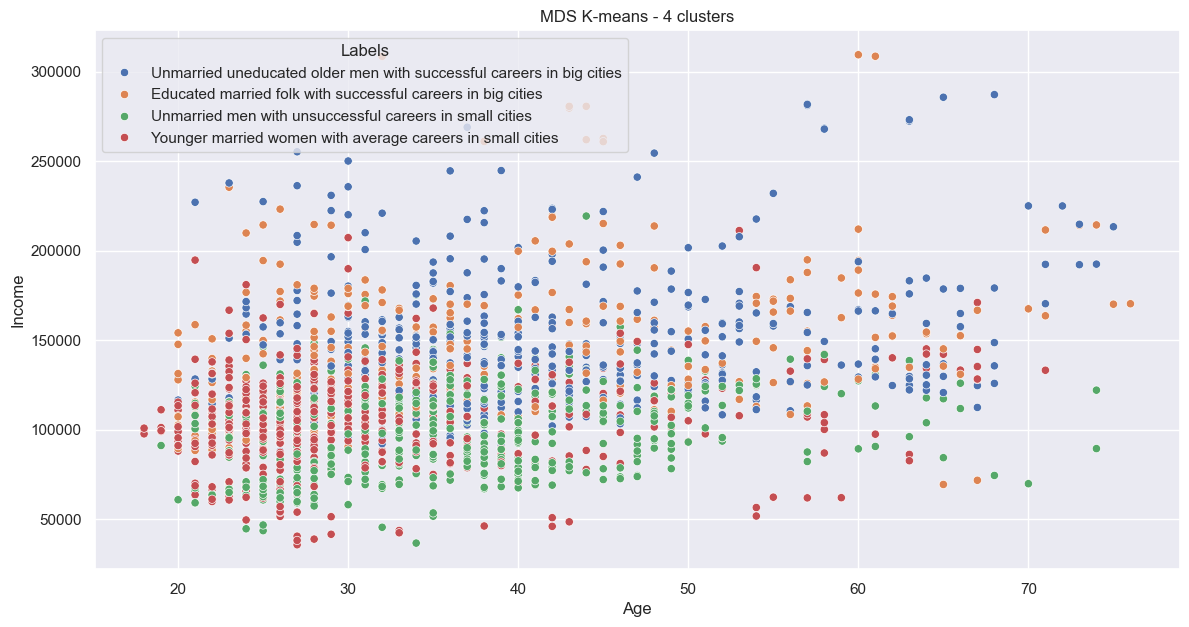

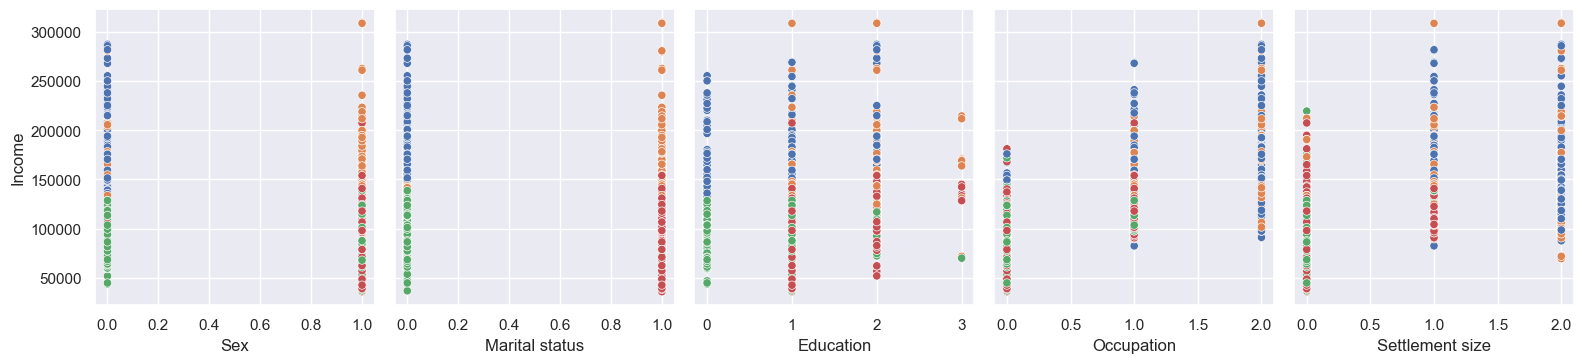

In [109]:
df_customers_mds_kmeans_4 = df_customers.copy()
df_customers_mds_kmeans_4['Cluster (MDS K-means)'] = clusters_mds_kmeans_4

display(df_customers_mds_kmeans_4.groupby(['Cluster (MDS K-means)']).mean().round(2))
display(df_customers_mds_kmeans_4.groupby(['Cluster (MDS K-means)']).median())
display(df_customers_mds_kmeans_4.groupby(['Cluster (MDS K-means)']).agg(lambda x: x.mode()[0]))

df_customers_mds_kmeans_4_analysis = df_customers_mds_kmeans_4.groupby(['Cluster (MDS K-means)']).mean()
df_customers_mds_kmeans_4_analysis['#'] = df_customers_mds_kmeans_4[['Cluster (MDS K-means)','Sex']].groupby(['Cluster (MDS K-means)']).count()
df_customers_mds_kmeans_4_analysis['%'] = df_customers_mds_kmeans_4_analysis['#'] / df_customers_mds_kmeans_4_analysis['#'].sum()

scaler_mds_kmeans_analysis_4 = MinMaxScaler()
df_customers_analysis_4_scaled = pd.DataFrame(scaler_mds_kmeans_analysis_4.fit_transform(df_customers_mds_kmeans_4_analysis), columns=df_customers_mds_kmeans_4_analysis.columns)
plt.figure(figsize=(12,4))
s = sns.heatmap(df_customers_analysis_4_scaled.drop(['#','%'], axis=1), annot=True, cmap='coolwarm', vmin=0, vmax=1)
s.set_yticklabels(s.get_yticklabels(), rotation=0)
plt.show()

mapping_mds_kmeans_4 = {0:'Unmarried uneducated older men with successful careers in big cities',
                        1:'Younger married women with average careers in small cities',
                        2:'Educated married folk with successful careers in big cities',
                        3:'Unmarried men with unsuccessful careers in small cities'}
df_customers_mds_kmeans_4_analysis.rename(mapping_mds_kmeans_4, inplace=True)
df_customers_mds_kmeans_4['Labels'] = df_customers_mds_kmeans_4['Cluster (MDS K-means)'].map(mapping_mds_kmeans_4)

display(df_customers_mds_kmeans_4_analysis)

plt.figure(figsize=(14, 7))
sns.scatterplot(data=df_customers_mds_kmeans_4, x='Age', y='Income', hue=df_customers_mds_kmeans_4['Labels'])
plt.title('MDS K-means - 4 clusters')
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(16,4), sharey=True)
for i, column in enumerate(df_customers_mds_kmeans_4.columns.drop(['Age','Income','Cluster (MDS K-means)','Labels'])):
    sns.scatterplot(data=df_customers_mds_kmeans_4, x=column, y='Income', hue=df_customers_mds_kmeans_4['Labels'], ax=axes[i])
    axes[i].legend().remove()
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

## Comparing techniques

### Similarity

In [110]:
df_customers_clusters = df_customers.copy()

df_customers_clusters['Hier_4'] = clusters_hier
df_customers_clusters['Gower_4'] = clusters_gower +1 # to make lowest value 1
df_customers_clusters['Kmeans_5'] = kmeans_5.labels_ +1
df_customers_clusters['Kmodes_3'] = clusters_kmodes_3 +1
df_customers_clusters['Kprot_3'] = clusters_kprot_3 +1
df_customers_clusters['Kprot_3'] = clusters_kprot_3 +1
df_customers_clusters['MDS_Kmeans_4'] = clusters_mds_kmeans_4 +1

df_customers_clusters['Clusters'] = df_customers_clusters[df_customers_clusters.columns[df_customers_clusters.columns.get_loc("Hier_4"):]].astype(str).agg(''.join, axis=1)
df_customers_clusters[['Clusters','Sex']].groupby(['Clusters']).count().sort_values('Sex', ascending=False).rename(columns={'Sex':'Count'})

Count
Clusters       
212212      166
221114      144
334321      141
134321      129
113222      110
...         ...
344233        1
345133        1
424134        1
444133        1
445233        1

[126 rows x 1 columns]

#### 3 clusters each

In [111]:
df_customers_clusters_3s = df_customers.copy()

clustering_gower_3 = AgglomerativeClustering(n_clusters=3, linkage='complete', metric='precomputed')
kmeans_3 = KMeans(n_clusters=3, init='k-means++', random_state=42)

df_customers_clusters_3s['Hierarchical'] = fcluster(linkage(df_customers, method='ward'), t=3, criterion='maxclust')
df_customers_clusters_3s['Gower'] = clustering_gower_3.fit_predict(gower_distance_matrix) +1 # to make lowest value 1
df_customers_clusters_3s['K-means'] = kmeans_3.fit(customers_scaled).labels_ +1
df_customers_clusters_3s['K-modes'] = clusters_kmodes_3 +1
df_customers_clusters_3s['K-prototypes'] = clusters_kprot_3 +1
df_customers_clusters_3s['MDS K-means'] = kmeans_3.fit(mds_fit).labels_ +1

df_customers_clusters_3s['Clusters'] = df_customers_clusters_3s[df_customers_clusters_3s.columns[df_customers_clusters_3s.columns.get_loc("Hierarchical"):]].astype(str).agg(''.join, axis=1)
df_customers_clusters_3s[['Clusters','Sex']].groupby(['Clusters']).count().sort_values('Sex', ascending=False).rename(columns={'Sex':'Count'})

Count
Clusters       
112212      275
122111      158
231321      154
131321      144
113213      116
...         ...
112113        1
212132        1
212232        1
222222        1
321131        1

[61 rows x 1 columns]

### Proportions

In [112]:
dict_of_pcs = {
    'Hierarchical': df_customers_hier_4_analysis.reset_index(drop=True)[['%']],
    'Gower distance': df_customers_gower_4_analysis.reset_index(drop=True)[['%']],
    'K-means': df_customers_kmeans_5_analysis.reset_index(drop=True)[['%']],
    'K-modes': df_customers_kmodes_3_analysis.reset_index(drop=True)[['%']],
    'K-prototypes': df_customers_kprot_3_analysis.reset_index(drop=True)[['%']],
    'MDS K-means': df_customers_mds_kmeans_4_analysis.reset_index(drop=True)[['%']]
}

for name, df in dict_of_pcs.items():
    df.index = df.index + 1

for name, df in dict_of_pcs.items():
    df = df.rename(columns={'%': name})
    dict_of_pcs[name] = df

df_clusters_pcs = pd.concat(dict_of_pcs.values(), axis=1)
df_clusters_pcs

Hierarchical  Gower distance  K-means  K-modes  K-prototypes  MDS K-means
1        0.4195          0.3680   0.1590    0.289        0.4435        0.266
2        0.2800          0.2420   0.2170    0.449        0.4500        0.289
3        0.2455          0.2615   0.2645    0.262        0.1065        0.185
4        0.0550          0.1285   0.2345      NaN           NaN        0.260
5           NaN             NaN   0.1250      NaN           NaN          NaN

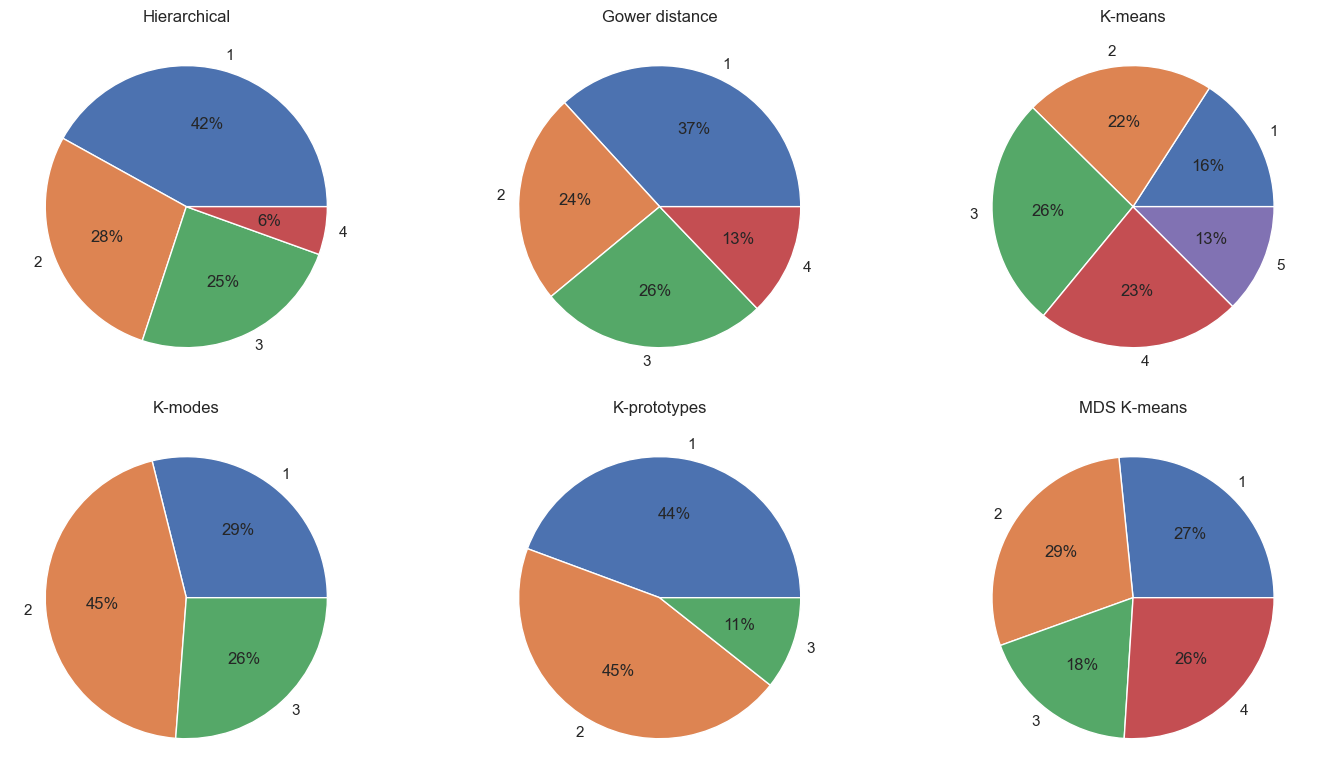

In [113]:
fig, axes = plt.subplots(2, 3, figsize=(15,8))
axes = axes.flatten()
for i, column in enumerate(df_clusters_pcs.columns):
    axes[i].pie(df_clusters_pcs[column].dropna(), labels=df_clusters_pcs.index[df_clusters_pcs[column].notna()], autopct='%1.0f%%')
    axes[i].set_title(column)
plt.tight_layout()
plt.show()


### Metrics

In [114]:
clustering_algorithms = ['Hier_4', 'Gower_4', 'Kmeans_5', 'Kmodes_3', 'Kprot_3', 'MDS_Kmeans_4']

scores = {}

for method in clustering_algorithms:
    labels = df_customers_clusters[method]
    silhouette = silhouette_score(df_customers_clusters.drop(columns=[method]), labels)
    davies_bouldin = davies_bouldin_score(df_customers_clusters.drop(columns=[method]), labels)
    scores[method] = {
        'Silhouette Score': silhouette,
        'Davies-Bouldin Index': davies_bouldin
    }

pd.DataFrame(scores).round(2)

Hier_4  Gower_4  Kmeans_5  Kmodes_3  Kprot_3  \
Silhouette Score        0.81    -0.10     -0.11     -0.02     0.14   
Davies-Bouldin Index    0.32     7.48      7.54      5.55     2.29   

                      MDS_Kmeans_4  
Silhouette Score             -0.09  
Davies-Bouldin Index         14.39

## Exporting

In [115]:
df_customers_final = df_customers.copy()
df_customers_final['Cluster'] = clusters_hier
df_customers_final.to_csv('customers-segmented.csv')

# End

1:'Very average',
2:'Below average careers, mostly younger married women',
3:'Above average careers, mostly older unmarried men',
4:'Older men with successful careers in big cities'

0:'Younger married educated women with average careers',
1:'Unmarried men with unsuccessul careers in small cities',
2:'Unmarried uneducated older men with successful careers in big cities',
3:'Younger married educated men with average careers'

0:'Unmarried uneducated men with unsuccessful careers in small cities',
1:'Young married women with unsuccessful careers in small cities',
2:'Young married men with average careers',
3:'Unmarried uneducated men with successful careers in big cities',
4:'Older folk with successful careers in middle cities'

0:'Unmarried men with unsuccessul careers in small cities',
1:'Younger married women with high education and average careers in smaller cities',
2:'Unmarried men with successful careers in big cities'

0:'Unmarried men with below-average careers in small cities',
1:'Very average',
2:'Older men with successul careers in bigger cities'

0:'Unmarried uneducated older men with successful careers in big cities',
1:'Younger married women with average careers in small cities',
2:'Educated married folk with successful careers in big cities',
3:'Unmarried men with unsuccessful careers in small cities'